In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pastas as ps
import datetime as dt
from scipy.stats import norm, probplot


ps.set_log_level("ERROR")

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

# Assessment of Time Series Models

A frequently asked question is how to evaluate an optimized time series model. This notebook presents methods for model evaluation and illustrates them with real-world examples.

**Table of Contents**

- [Introduction](#Introduction)
- [Visual Evaluation](#Visual-Evaluation)
- [Fit Statistics](#Fit-Statistics)
- [Model Testing](#Model-Testing)
- [Model Uncertainty](#Model-Uncertainty)
- [Hydrological Evaluation](#Hydrological-Evaluation)
- [References](#References)

## Introduction

When deciding whether to use or reject a time series model, it is important to first determine the purpose of the model. Based on this purpose, criteria can be established for evaluating the model. 

This notebook provides an overview of commonly used methods for assessing time series models. For each topic, the most important background information is presented. This document does not offer a complete overview of all research and work done in this area. For readers interested in exploring the topic further, we have included references for deeper study.

### General Evaluation Steps

Here we present a number of steps that are commonly used to assess time series models. There is no such thing as a definitive step-by-step plan for model evaluation, so there are also other methods not included in this notebook. The order of the steps is not fixed, but logically structured according to the authors' insights.

- **Visual Evaluation:** A good first step is often a visual inspection of the time series model. The behavior of the model is visually inspected, which often provides many valuable insights. The downside of this step is that it can be relatively time-consuming when many models are involved.

- **Fit Statistics:** The second step involves assessing the agreement between model and measurements (the fit) based on statistical measures. The advantage of this step is that it provides an objective measure of how well the model matches the data. The downside is that a lot of valuable information is lost when reducing the model’s performance to just a few numbers.

- **Model Testing:** The third step is testing the model (often called validation), for example by simulating a period of measurements that was not used in calibration. This tests how well the model performs on data that was not used to optimize the model parameters.

- **Model Uncertainty:** The fourth step involves considering the model’s uncertainty. This raises the question: can the model parameters be reliably estimated? Before this uncertainty can be assessed, the model must meet certain statistical requirements. If the model does not meet these requirements, the uncertainty of the parameters cannot be properly evaluated—and therefore cannot be used in the assessment. The parameters may be well estimated, but their uncertainties are not.

- **Hydrological Evaluation:** The final step we present here is the hydrological evaluation, where the results of the time series models are compared with hydrological knowledge of the system. This can be done for individual time series models as well as spatially across the results of multiple models. Here, hydrological system knowledge is used to assess the models, but the model results are also used to expand our understanding of the hydrological system.

In [2]:
def plot_results_ml(ml):
    """Plot model simulation and residuals.

    Model simulation and observations in top axes, residuals on
    second set of axes.

    Paramters
    ---------
    ml : pastas.Model
        plot results for model

    Returns
    -------
    fig : Figure
        return figure handle

    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ml.plot(ax=ax1, legend=False)
    ax1.set_ylabel('stijghoogte [m NAP]')
    ax1.grid()
    handles, labels = ax1.get_legend_handles_labels()
    labels = ['Head', 'Simulation']
    ax1.legend(handles, labels, loc="upper left", ncol=2)
    ml.residuals().plot(ax=ax2, color="C1", label="residuals")
    ax2.axhline(0.0, linestyle="dashed", color="k", lw=1.5)
    ax2.set_ylabel('residuen [m]')
    ax2.grid()
    fig.tight_layout()

    return fig


def fit_stats_model(ml):
    """Fit statistics for a model

    Parameters
    ----------
    ml : pastas.Model
        calculate stats for model

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing statistics

    """
    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of the squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=["value", "unit"])
    # fit statistics kunnen in pastas worden opgevraagd met:
    # `<model>.stats.<naam statische parameter>()`
    df.loc[stats[0], :] = ml.stats.mae(), "m"
    df.loc[stats[1], :] = ml.stats.rmse(), "m"
    df.loc[stats[2], :] = ml.stats.sse(), "m$^2$"
    df.loc[stats[3], :] = ml.stats.evp(), "%"
    df.loc[stats[4], :] = ml.stats.rsq(), "-"

    df["value"] = df["value"].astype(float)

    return df


def get_stats_train_test(ml, train_tmin, train_tmax,
                         test_tmin, test_tmax):
    """Get statistics for training and testing periods

    Paramters
    ---------
    ml : pastas.Model
        calculate train/test stats for model
    train_tmin : str, pd.Timestamp
        start time for training period
    train_tmax : str, pd.Timestamp
        end time for training period
    test_tmin : str, pd.Timestamp
        start time for testing period
    test_tmax : str, pd.Timestamp
        start time for testing period

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing statistics for training/testing
        periods

    """
    sim = ml.simulate(tmin=train_tmin, tmax=train_tmax)
    obs = ml.oseries.series_original[train_tmin:str(int(train_tmax)-1)]

    stats = [
        "Mean absolute error (mae)",
        "Root mean squared error (rmse)",
        "Sum of squares of the error (sse)",
        "Explained variance percentage (evp)",
        "R-squared (rsq)"
    ]

    df = pd.DataFrame(index=stats, columns=[
                      f"training: {train_tmin}-{train_tmax}",
                      f"test: {test_tmin}-{test_tmax}", "unit"])

    # statistieken periode 1985 - 2000
    df.loc[stats[0], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3],
           f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"training: {train_tmin}-{train_tmax}"] = \
        ps.stats.rsq(obs=obs, sim=sim)

    # statistieken periode 2000 - 2015
    sim = ml.simulate(tmin=test_tmin, tmax=test_tmax)
    obs = ml.oseries.series_original[test_tmin:str(int(test_tmax)-1)]
    df.loc[stats[0], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.mae(obs=obs, sim=sim)
    df.loc[stats[1], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.rmse(obs=obs, sim=sim)
    df.loc[stats[2], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.sse(obs=obs, sim=sim)
    df.loc[stats[3], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.evp(obs=obs, sim=sim)
    df.loc[stats[4], f"test: {test_tmin}-{test_tmax}"] = \
        ps.stats.rsq(obs=obs, sim=sim)

    df.loc[:, "unit"] = ["m", "m", "m$^2$", "%", "-"]

    for icol in df.columns[:-1]:
        df[icol] = df[icol].astype(float)

    return df

In [3]:
# set options to display DataFrames in PDF
#pd.set_option("display.latex.repr", True)
#pd.set_option("display.latex.longtable", True)


def _repr_latex_(self):
    latex = """\\begin{center}
    {%s}
    \\end{center}""" % self.to_latex(float_format="{:0.3f}".format, bold_rows=True)
    return latex


pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

In [4]:
# %%html
# <style>
# table {float: left}
# </style>

## Visual Evaluation

A simple way to evaluate a time series model is by visualizing the results. The model simulation is displayed in a graph alongside the observations. Often, the model residuals are also shown. 

Based on both graphs, it can be visually assessed whether the simulation aligns well with the measurements, or whether the measurements are poorly approximated. It also allows for evaluating in which periods the model performs well, and in which it does not. 

For example, is the model able to accurately simulate the peaks and troughs?

<hr>

#### Example of Visual Evaluation 1

As an example of a visual evaluation, a time series model has been selected in which the groundwater head is explained based on precipitation and evaporation. The model simulation (blue line) and the measurements (black dots) are shown in the top graph. The residuals (orange line) are shown in the bottom graph.

The figure shows that the simulation and the measurements match well. The residuals reveal that the largest differences between model and measurements occur at the extremes: the dips in summer and the peaks in winter. However, the residuals do not show a clear pattern and are evenly distributed around the zero line, indicating that there is no structural error in the model.

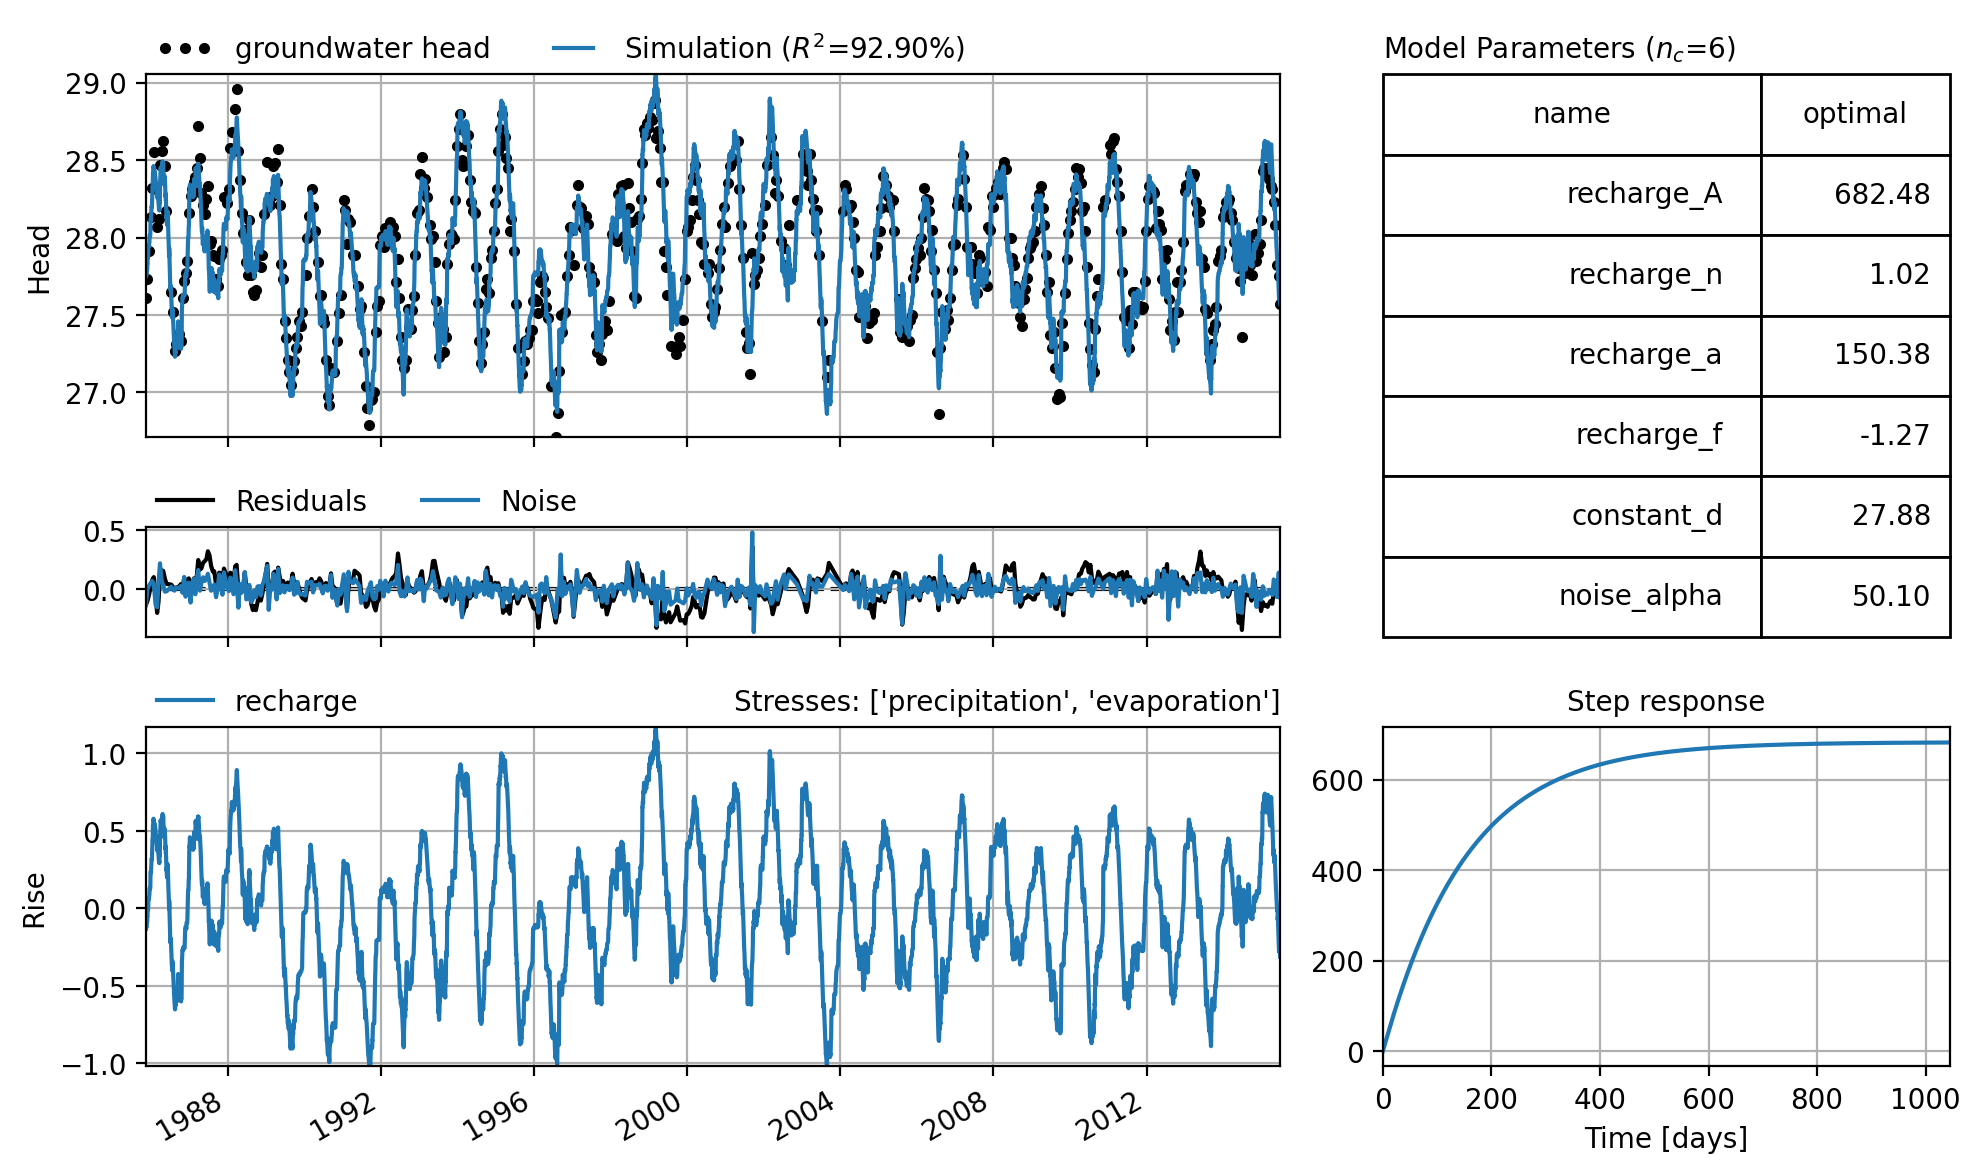

In [5]:
head = pd.read_csv("data/hds_basic_model.csv", parse_dates=True, index_col=0)
head = head.iloc[:, 0]  # Convert from DataFrame to Series

prec = pd.read_csv("data/prec_basic_model.csv", parse_dates=True, index_col=0)
prec = prec.iloc[:, 0]

evap = pd.read_csv("data/evap_basic_model.csv", parse_dates=True, index_col=0)
evap = evap.iloc[:, 0]


head.name = "groundwater head"
prec.name = "precipitation"
evap.name = "evaporation"


ml1 = ps.Model(head, name='Head')
rm = ps.RechargeModel(prec, evap, recharge=ps.rch.Linear(),
                      rfunc=ps.Gamma(), name="recharge")
ml1.add_stressmodel(rm)
ml1.add_noisemodel(ps.ArNoiseModel())

ml1.solve(report=False, fit_constant=True)

fig = ml1.plots.results(figsize=(10, 6), adjust_height=True)

plt.tight_layout()
plt.show()

<hr>

#### Example of Visual Evaluation 2

The example below shows a time series model where the model simulation (blue line) poorly matches the measurements (black dots). The simulation deviates by as much as 2 meters from the observed groundwater heads. It is not possible to produce reliable simulations with this model.

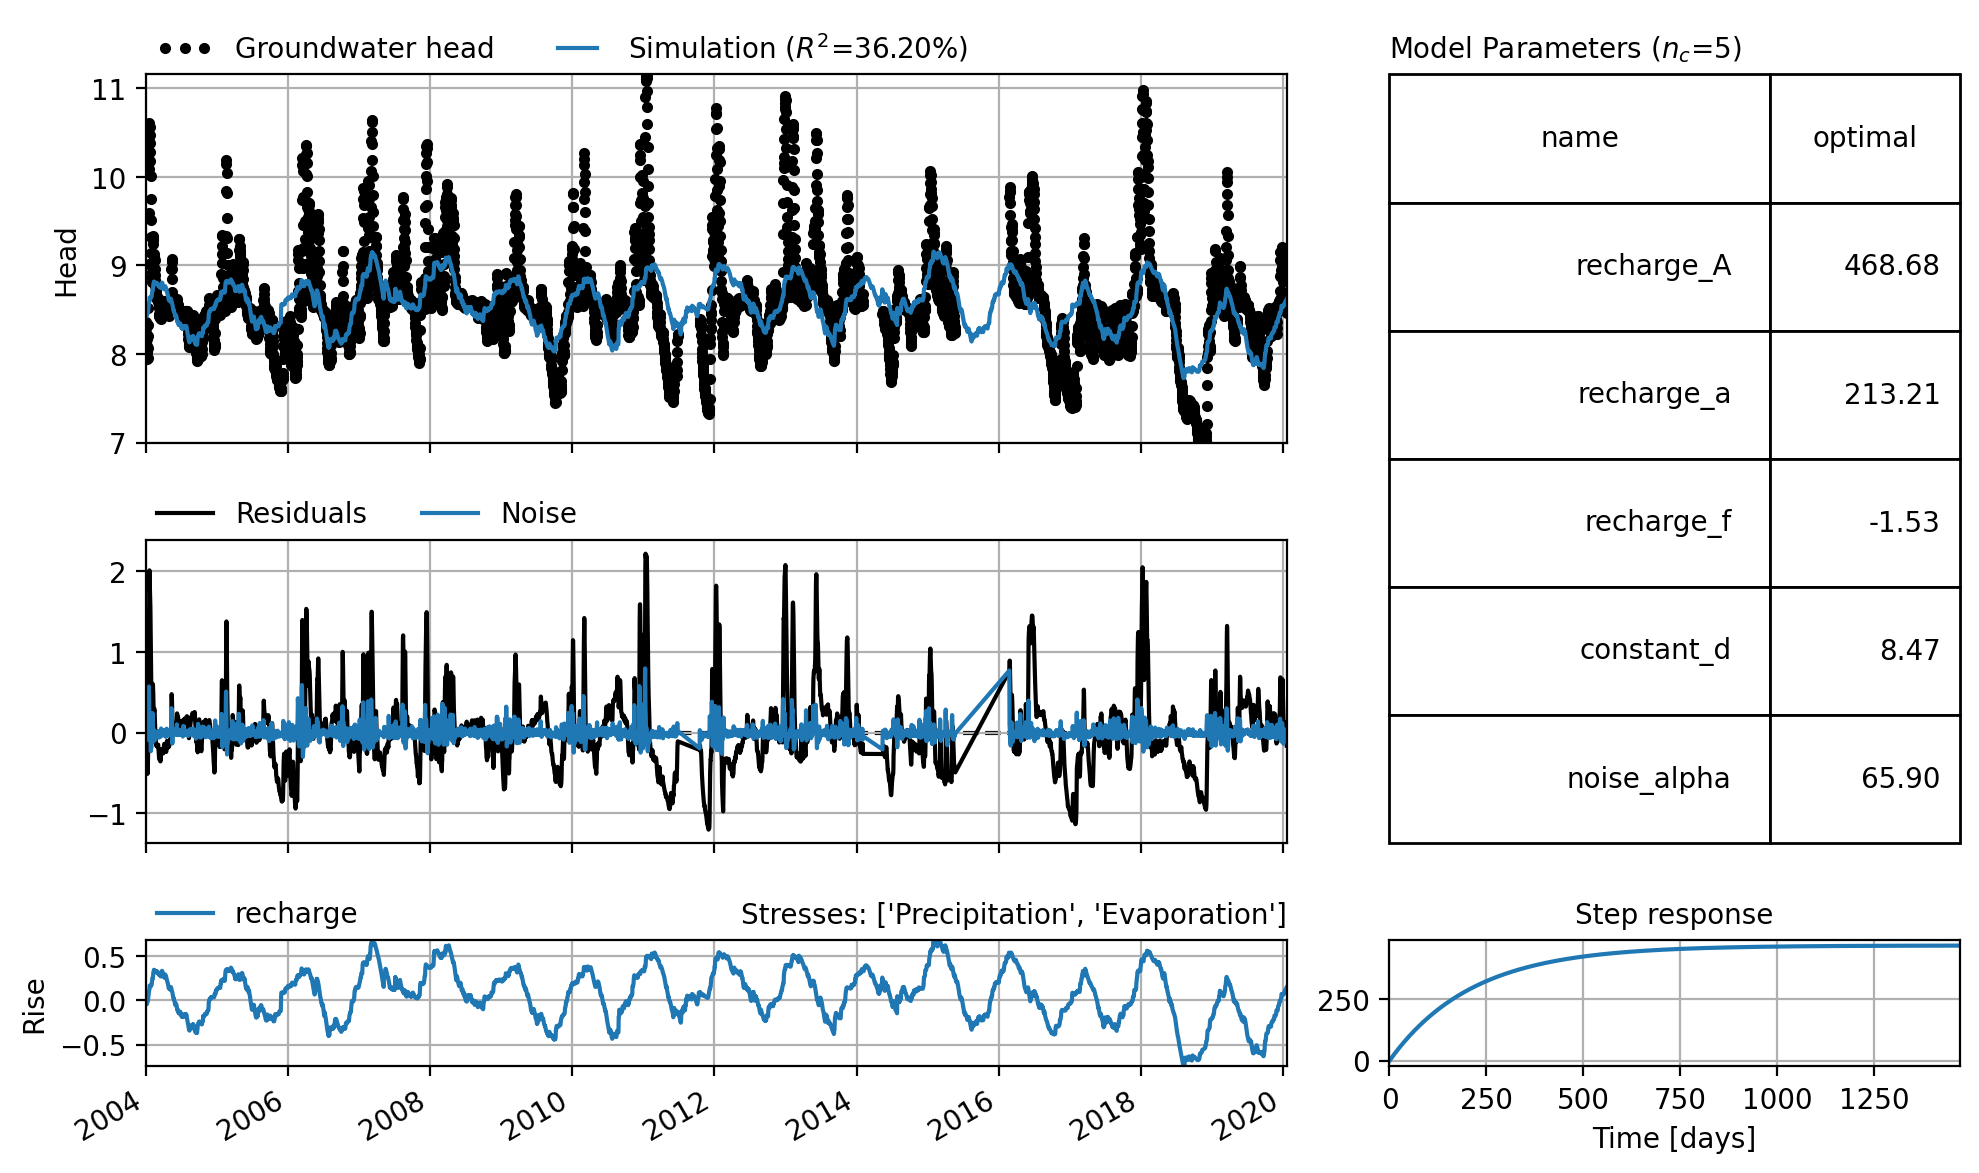

In [6]:
head2 = pd.read_csv("data/hds_vb_model2.csv", parse_dates=True, index_col=0)
head2 = head2.iloc[:, 0] 

prec2 = pd.read_csv("data/prec_vb_model2.csv", parse_dates=True, index_col=0)
prec2 = prec2.iloc[:, 0]

evap2 = pd.read_csv("data/evap_vb_model2.csv", parse_dates=True, index_col=0)
evap2 = evap2.iloc[:, 0]

head2.name = "Groundwater head"
prec2.name = "Precipitation"
evap2.name = "Evaporation"

ml_visual2 = ps.Model(head2, name='Head')
rm2 = ps.RechargeModel(prec2, evap2, recharge=ps.rch.Linear(),
                       rfunc=ps.Exponential(), name="recharge")
ml_visual2.add_stressmodel(rm2)
ml_visual2.add_noisemodel(ps.ArNoiseModel())

# optimaliseer model
ml_visual2.solve(tmin="2004", report=False, fit_constant=True)


fig = ml_visual2.plots.results(figsize=(10, 6), adjust_height=True)

plt.tight_layout()
plt.show()

<hr>

## Fit Statistics

In addition to visual evaluation, model results can also be assessed using statistical parameters. There are various statistical measures that express the fit between simulated and observed groundwater heads numerically. These statistics can be divided into those that express the model error (the residuals) as a single number, and those that attempt to quantify the "goodness-of-fit" in a single value.

The table below includes several commonly used statistics. For an overview of different fit statistics frequently applied in hydrology, see [Jackson et al. (2019)](#References).

It is recommended to consider multiple fit statistics simultaneously when evaluating time series models. Each statistic has its own specific purpose, and no single number can capture all the complexity related to a model's fit.

<!-- | afkorting         | naam                               | formule                                                                                          | optimale waarde | min          | max      | type            |
|:------------------|:-----------------------------------|:------------------------------------------------------------------------------------------------:|:---------------:|:------------:|:--------:|----------------:|
| $\text{SSE}$      | som kwadratische fout              | $$\sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2$$                                                     | 0               | 0         | $\infty$ | residuën        |
| $\text{MAE}$      | gemiddelde absolute fout           | $$\sum\limits_{i=1}^{N}\frac{ \left| y_i - \hat{y_i} \right| }{N}$$                              | 0               | 0         | $\infty$ | residuën        |
| $\text{RMSE}$     | wortel kwadratisch gemiddelde fout | $$\sqrt{ \sum\limits_{i=1}^{N} \frac{ (y_i - \hat{y_i})^2}{N}}$$                                 | 0               | 0         | $\infty$ | residuën        |
| $\text{EVP}^{**}$ | verklaarde variantie               | $$\frac{ \sigma_y^2 - \sigma_r^2}{\sigma_y^2} \cdot 100$$                                        | 100%            |-$\infty^*$ | 100      | goodness-of-fit |
| $R^2$             | determinatiecoëfficient$^{***}$     | $$1 - \frac{ \sum\limits_{i=1}^{N}(y_i - \hat{y_i})^2}{\sum\limits_{i=1}^{N}(y_i - \bar{y})^2}$$ | 1               | -$\infty$ | 1        | goodness-of-fit | -->

<!-- <img src="data/fit_stats_table.png" width="800"> -->
![fit statistics table](data/fit_stats_table.png)

$^{*}$ In various time series analysis programs, including Menyanthes and Pastas, the minimum value of the EVP is limited to 0.

$^{**}$ [Von Asmuth (2012)](#References)

$^{***}$ The coefficient of determination is also often referred to as the Nash-Sutcliffe model efficiency (NSE) coefficient in hydrological models.

In the formulas above, $N$ is the number of measurements, $y_i$ and $\hat{y_i}$ are the observed and model-fitted groundwater heads at time $i$, respectively. $\bar{y}$ is the mean of the observations. $\sigma_y^2$ and $\sigma_r^2$ are the variance of the observed groundwater heads and the variance of the residuals $r$, respectively, where $\sigma_y^2 = \tfrac{1}{N} \sum\limits_{i=1}^{N}\left(y_i - \bar{y} \right)^2$ and $\sigma_r^2 = \tfrac{1}{N} \sum\limits_{i=1}^{N}\left(r_i - \bar{r} \right)^2$.

#### Difference Between MAE and RMSE

The **Mean Absolute Error (MAE)** is the average of the absolute values of all errors. This means that each error is weighted equally. 

The **Root Mean Squared Error (RMSE)**, on the other hand, squares the errors, giving relatively greater weight to larger errors.

#### Difference Between $R^2$ and $\text{EVP}$

The Explained Variance ($\text{EVP}$) and the Coefficient of Determination ($R^2$) are subtly different. The value of $\text{EVP}$ is equal to $R^2$ when the mean of the residuals is equal to zero. 

The optimization of a time series model aims to fit the model such that the mean of the residuals is zero, so in practice, these statistics often have the same value.

<hr>

#### Example of Fit Statistic 1

The fit statistics of the first model shown above are listed in the table below. The mean absolute model error is approximately 9 cm. The fit statistics indicate that the model matches the observations well; the explained variance (or EVP) is 92.9%.

In [7]:
# bereken statistieken tabel
df = fit_stats_model(ml1)

# geef tabel weer
# df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_1")
df.round(3)

,value,unit
Mean absolute error (mae),0.090,m
Root mean squared error (rmse),0.114,m
Sum of the squares of the error (sse),8.442,m$^2$
Explained variance percentage (evp),92.905,%
R-squared (rsq),0.929,-


<hr>

#### Example of Fit Statistic 2

The fit statistics of the second example model are significantly worse. As already shown visually, the model does not match the observations well. The explained variance (EVP) is only 39.6%, and the mean absolute error (MAE) is as high as 31 cm.

In [8]:
# bereken statistieken tabel
df = fit_stats_model(ml_visual2)

# geef tabel weer
# df.style.set_precision(3).set_caption("Fit statistieken voorbeeld_model_2")
df.round(3)

,value,unit
Mean absolute error (mae),0.314,m
Root mean squared error (rmse),0.452,m
Sum of the squares of the error (sse),1097.701,m$^2$
Explained variance percentage (evp),36.210,%
R-squared (rsq),0.362,-


<hr>

### Overfitting

When more explanatory variables (and thus model parameters) are added to a time series model, the fit generally improves, even if the explanatory variable has little or no actual influence on the groundwater head. The model can use these extra degrees of freedom (parameters) to better fit the measurements. However, adding a non-relevant explanatory variable does not improve the model’s predictive value.

The phenomenon where more parameters are added to a model than justified by the data is called **overfitting**. Overfitting can often be recognized by the standard errors of the parameters (see [Model Uncertainty](#Model-Uncertainty)) ([Van Geer, 2012](#References)).

There are statistics that compute a relative score based on the model fit, while penalizing for the number of parameters. These help assess whether the addition of parameters has led to a significant model improvement. The **Akaike Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)** are two examples. Both AIC and BIC are measures of the relative amount of information lost in the model (so-called "penalized likelihood criteria"). They are **relative values** and are used to compare different models for the same observation series.

If the AIC and BIC decrease after adding an explanatory variable, it means the model has improved (less information is lost). If the AIC and BIC increase, the added parameter has not contributed sufficiently to improving the model.

For this notebook, it is only important to understand that the difference between AIC and BIC lies in how they penalize the number of parameters. BIC generally penalizes additional parameters slightly more heavily than AIC.

In summary, these statistics can be used to compare different time series models for the same observation well (with different model structures). They provide a relative score for the fit (how well the model matches the data), while penalizing for model complexity. The lower the statistic, the less information is lost in the model, and the better the model may be.

<hr>

#### Example: AIC/BIC

In this example, we create a time series model for a monitoring point (40CP0393, filter 4) where precipitation and evaporation are linearly combined as an estimate of groundwater recharge. We optimize the model and calculate the EVP, AIC, and BIC. Next, we add the influence of river water level to the time series model. First, we use the exponential response function (2 parameters), and then we repeat the process using the Gamma response function (3 parameters). For both models, we again calculate the EVP, AIC, and BIC. The resulting table shows that adding the river as a stress leads to a significant improvement. The EVP increases substantially, and both AIC and BIC decrease significantly.

Based on the EVP, we would conclude that the model with the river and the Gamma response function performs best. The AIC is also lowest for this model, indicating that the improvement in fit quality justifies the addition of an extra parameter. Based on the AIC, we would again select this model as the best. However, the BIC—which penalizes additional parameters more heavily—is lowest for the model with the river and the exponential response function. According to BIC, that model is preferred.

Unfortunately, in this case, the statistics do not give a clear-cut answer, so it is up to the user to make a choice. Given the small difference in both AIC and BIC between the time series models with the river, either model is sufficiently good for further analysis.

In [9]:
df = pd.DataFrame(
    index=["model without river",
           "model with river (Exponential)",
           "model with river (Gamma)"],
    columns=["EVP", "AIC", "BIC"], data=np.nan
)

head = pd.read_csv("../model_structure/data/40CP0393-004.csv", index_col=0, parse_dates=True).iloc[:, 0]
prec = pd.read_csv("../model_structure/data/RD_Nijmegen.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3
evap = pd.read_csv("../model_structure/data/EV24_Deelen.csv", index_col=0, parse_dates=True).iloc[:, 0] * 1e3

# Maak model o.b.v. grondwateraanvulling
ml = ps.Model(head, name="40CP0393 (screen 4)")
ml.add_noisemodel(ps.ArNoiseModel())
sm = ps.RechargeModel(prec, evap, name="rch",
                      recharge=ps.rch.Linear(), rfunc=ps.Gamma())
ml.add_stressmodel(sm)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model without river"] = ml.stats.evp(), ml.stats.aic(), ml.stats.bic()

# Voeg rivier toe met Exponential respons
river = pd.read_csv("../model_structure/data/40CP0393-rivier.csv", index_col=0, parse_dates=True).iloc[:, 0]

sm2 = ps.StressModel(river, name="river", rfunc=ps.Exponential())
ml.add_stressmodel(sm2)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model with river (Exponential)"] = ml.stats.evp(
), ml.stats.aic(), ml.stats.bic()

# Voeg rivier toe met Gamma respons
ml.del_stressmodel("river")
sm2 = ps.StressModel(river, name="river", rfunc=ps.Gamma())
ml.add_stressmodel(sm2)
ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=True)
df.loc["model with river (Gamma)"] = ml.stats.evp(
), ml.stats.aic(), ml.stats.bic()

# Geef tabel weer
# df.style.set_precision(3)
df.round(3)

,EVP,AIC,BIC
model without river,58.876,-30893.072,-30855.291
model with river (Exponential),94.313,-31299.280,-31248.905
model with river (Gamma),94.487,-31298.133,-31241.462


## Model Testing

The purpose of this step is to check whether the model is suitable for its intended purpose. This step is also often referred to as model validation (for a discussion on the correct terminology, see for example [Konikow et al. (1992)](#References)). Cross-validation (in English: 'split-sample testing') is a commonly used method in rainfall-runoff hydrology to test models. It is a way to assess the predictive value of a model. In this method, we split a time series into two parts: a training part and a test part. The part of the measurements we use to calibrate the model is called the training set. We then use the calibrated model to compute a simulation for the second period. This part is called the test set. We compare the test set to the measurements to evaluate whether the model also performs well for the part it was not calibrated on. A time series must be sufficiently long and contain enough measurements to be split into a training part and a test part.

The [fit statistics](#Fit-statistics) discussed above can also be used to evaluate the prediction during a test period. For a comprehensive analysis of a set of time series models using this method, including a discussion of the associated fit statistics, see [Knotters (2012)](#References).

<hr>

#### Model Test Example 1

The example model above was tested by splitting the dataset into two periods. The model was trained on the period 1985–2000 and tested on the period 2000–2015. The results are shown in the graphs below, along with the calculated fit statistics for both periods.

The model performs quite well in the test period, which gives confidence in its predictive value. Although the NSE is 3 percentage points lower in the test period compared to the training period, it still remains relatively high at 90.5%. The fit statistics clearly show that the model performs similarly in the test period compared to the training period.

In [10]:
train_tmin, train_tmax = "1985", "2000"
test_tmin, test_tmax = "2000", "2015"

ml_train1 = ml1.copy()
ml_train1.solve(tmin=train_tmin, tmax=train_tmax, report=False)

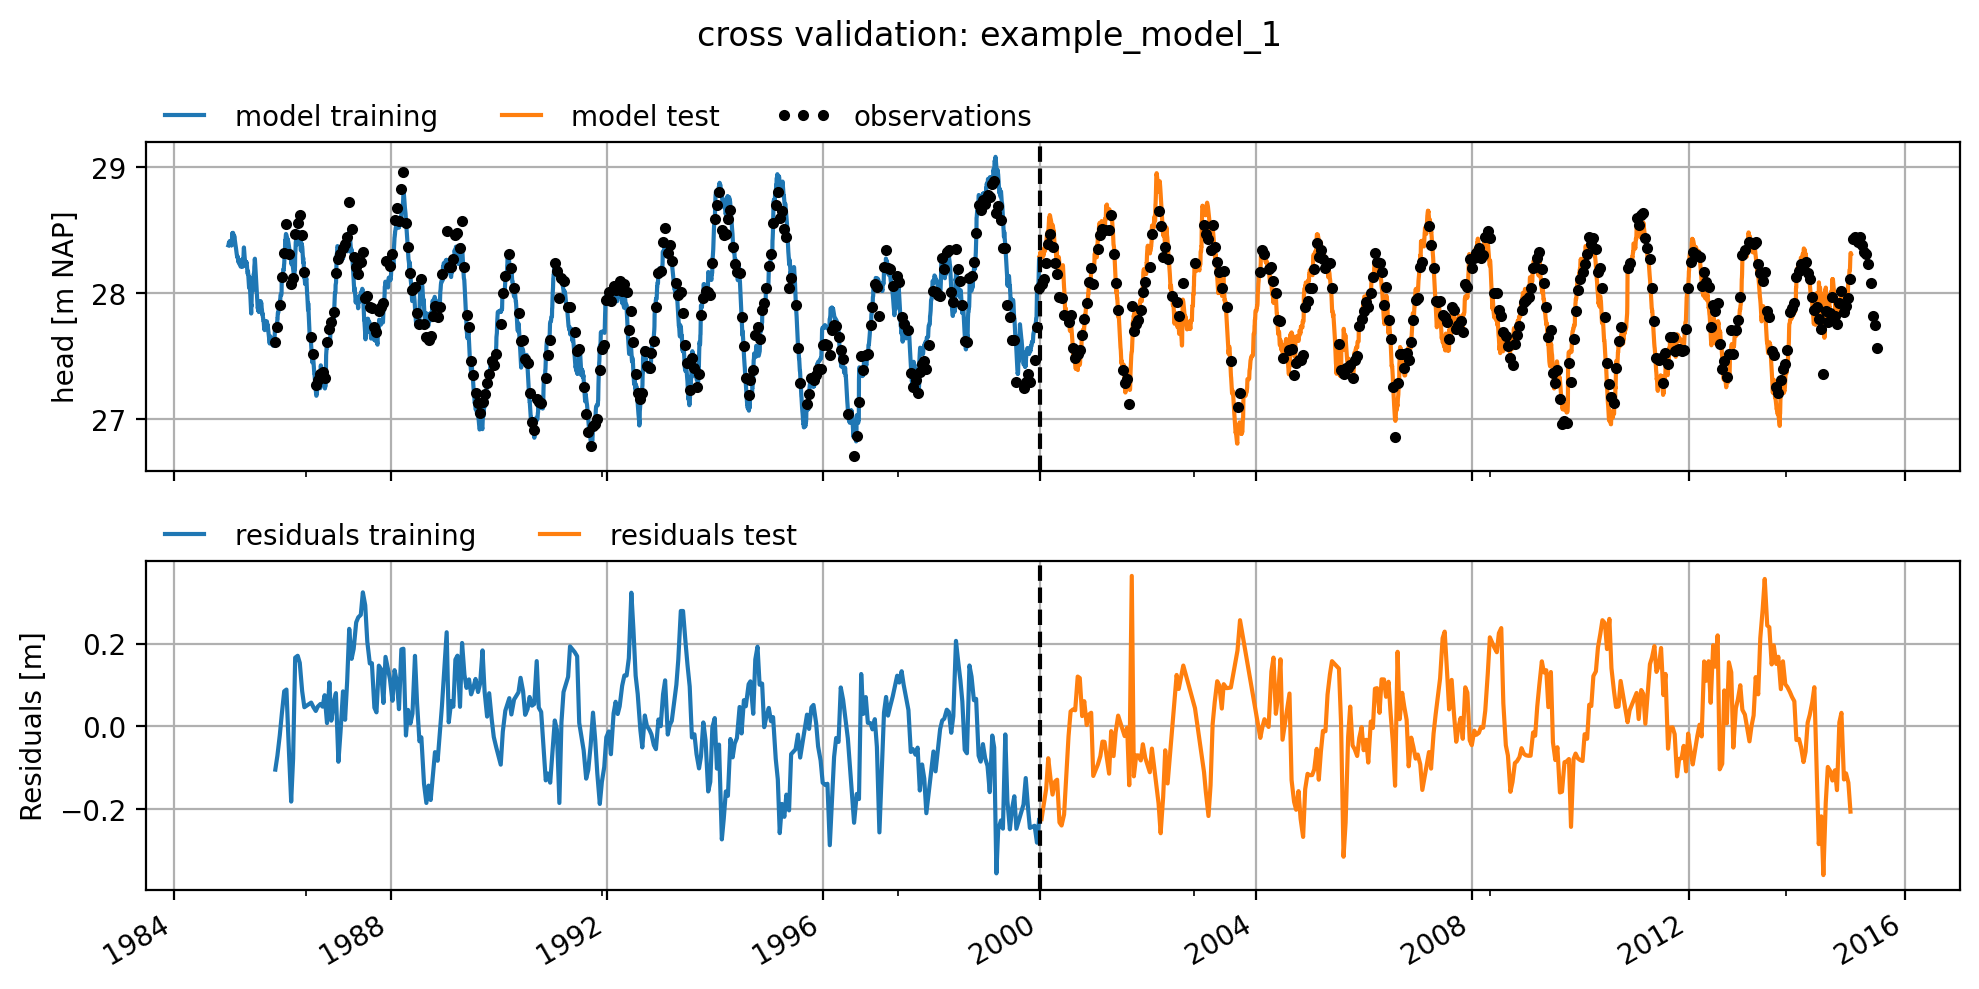

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

ax1.plot(ml_train1.simulate(tmin=train_tmin, tmax=train_tmax), label='model training')
ax1.plot(ml_train1.simulate(tmin=test_tmin, tmax=test_tmax), label='model test')
ax1.plot(ml_train1.oseries.series_original, ls='', marker='.', label='observations', color='k')
ax1.legend(loc=(0, 1), frameon=False, ncol=3, numpoints=3)
ax1.grid()
fig.suptitle('cross validation: example_model_1')
ax1.set_ylabel('head [m NAP]')
ax1.axvline(pd.Timestamp(train_tmax), linestyle="dashed", lw=1.5, color="k")


ml_train1.residuals(tmin=train_tmin, tmax=train_tmax).plot(ax=ax2, label="residuals training")
ml_train1.residuals(tmin=test_tmin, tmax=test_tmax).plot(ax=ax2, label="residuals test")

ax2.axvline(pd.Timestamp(test_tmin), linestyle="dashed", lw=1.5, color="k")
ax2.set_ylabel('Residuals [m]')
ax2.legend(loc=(0, 1), frameon=False, ncol=3, numpoints=3)

ax2.grid()
fig.tight_layout()


In [12]:
df = get_stats_train_test(ml_train1, train_tmin, train_tmax,
                          test_tmin, test_tmax)
df.round(3)

,training: 1985-2000,test: 2000-2015,unit
Mean absolute error (mae),0.098,0.098,m
Root mean squared error (rmse),0.123,0.122,m
Sum of squares of the error (sse),4.781,4.744,m$^2$
Explained variance percentage (evp),93.345,89.498,%
R-squared (rsq),0.933,0.895,-


<hr>

If the model performs well during the test period, then the model derived based on the training period is good enough to predict groundwater heads. This gives confidence that the model performs well, but it does not necessarily mean that the model will also make good predictions in the future. If something changes structurally in the system in the future (e.g., a new abstraction starts pumping outside both selected periods), the model will, of course, not be able to predict that correctly.

If the model shows a good fit during the training period but not during the test period, then the model is not a good predictor of groundwater head. This can have several causes. Possible reasons include changes in the system that occurred during the test period, such as the start of a new abstraction or the filling in of a ditch, or the inclusion of an influence in the model that was not yet active during the training period, or overfitting.


<hr>

#### Model Test Example 2

Below is an example of a model with a good fit during the training period and a poor (or less good) fit during the test period. The poor fit is caused by an as yet unexplained trend in the groundwater head. This trend is possibly due to an external influence that was not included during the training of the model. As a result, it is not possible to achieve a good fit for the test period using this model.

In [13]:
head2 = pd.read_csv('../model_structure/data/B32C0609001_1.csv', skiprows=15, index_col=2, parse_dates=True).iloc[:, 4].astype(float)/100
raw = pd.read_csv('../model_structure/data/etmgeg_260.txt', skiprows=47, index_col=1, parse_dates=True).replace("     ", np.nan)


rain = pd.to_numeric(raw['   RH']) *1e3
evap = pd.to_numeric(raw[' EV24']) *1e3

rain.name = "Precipitation"
evap.name = "Evaporation"

ml_cross_validation = ps.Model(head2, name="B32C0609 (filter 1)")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch,
                      rfunc=ps.Exponential(), name="rch")
ml_cross_validation.add_stressmodel(rm)

# train en test periode definieren
train_tmin, train_tmax = "1990", "2005"
test_tmin, test_tmax = "2005", "2019"

# Solve the model
ml_cross_validation.solve(tmin=train_tmin, tmax=train_tmax,
                         initial=False, report=False, fit_constant=True)

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.Columns (2,3,4,5,6,7,8,13,15,16,18,19,20,21,22,23,25,26,28,30,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.

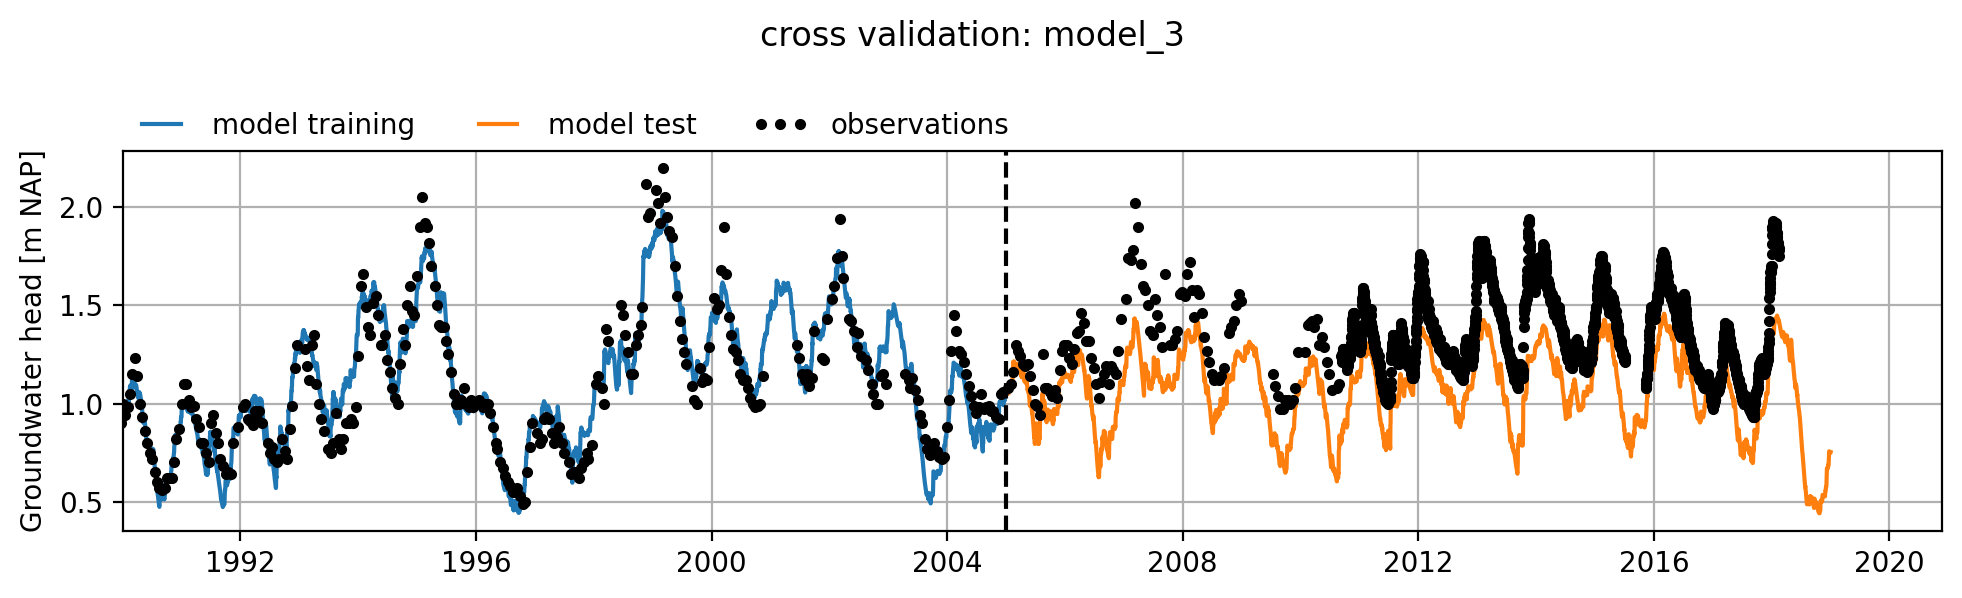

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ml_cross_validation.simulate(
    tmin=train_tmin, tmax=train_tmax), label='model training')
ax.plot(ml_cross_validation.simulate(
    tmin=test_tmin, tmax=test_tmax), label='model test')
ax.plot(ml_cross_validation.oseries.series_original, ls='',
        marker='.', label='observations', color='k')
ax.set_xlim(left=pd.Timestamp(train_tmin))
ax.axvline(pd.Timestamp(train_tmax), linestyle="dashed",
           lw=1.5, color="k")
ax.legend(loc=(0, 1), frameon=False, ncol=3, numpoints=3)
ax.grid()
ax.set_ylabel('Groundwater head [m NAP]')
fig.suptitle('cross validation: model_3')
fig.tight_layout()

<hr>

## Model Uncertainty

Every time series model involves a certain level of uncertainty. This uncertainty can be divided into uncertainty about the model structure and uncertainty in the model parameters. In this notebook, only the uncertainty of the model parameters is discussed, but there is a relationship between these two forms of model uncertainty. A large uncertainty in the parameters may indicate a suboptimal model structure, and conversely, a suboptimal model structure often manifests as greater uncertainty in the model parameters. For an explanation of the model structure of time series models, see the [Notebook Model Structure](../model_structuur/model_structuur.ipynb). 

In time series modeling according to the PIRFICT method, external influences are modeled with response functions, each containing one or more parameters [(Asmuth, 2002)](#References). In addition, a constant and a noise model can also be added to time series models. Time series models can be evaluated based on the calculated uncertainties of these model parameters. It is easy to imagine that a model with parameters that are difficult to estimate (i.e., uncertain parameters) is less reliable than a model whose parameters can be estimated accurately (i.e., with low uncertainty).

To assess the uncertainties of the parameters, the series being minimized (the residuals or the noise) must meet certain statistical requirements. A noise model is often applied to ensure that the model satisfies these statistical criteria. The requirements for the residuals/noise are that it:

- behaves like white noise with a mean of zero. There is white noise when:
  - there is no significant autocorrelation in the noise;
  - the noise is homoscedastic, meaning the standard deviation of the noise is constant;
  - the noise follows, preferably, a normal statistical distribution.
- is not correlated with any explanatory time series.

This notebook does not explain the consequences of not meeting these requirements; for that, see the [Notebook Model Calibration](../kalibratie/kalibratie_notebook.ipynb). However, it does show how these requirements can be visually assessed. In addition to visual assessment, there are various diagnostic tests that statistically evaluate whether these requirements are met. The advantage of these tests is that they are more objective than visual inspection. The downside is that they often only work for equidistant time steps and therefore, formally, should not be applied to series with variable time steps. See for example [this notebook on the Pastas website](https://pastas.readthedocs.io/en/latest/examples/003_diagnostic_checking.ipynb.html) for implementation and a more detailed description of such diagnostic tests [(Collenteur et al., 2019)](#References).

In summary, the calculated uncertainties of the parameters may be used in further analysis if the statistical requirements mentioned above are met.


<hr>

#### Example: Reliability of Model Parameters

The standard deviation of the model parameters has been calculated for the first example model and is shown in the table below. The standard deviation of the estimated parameters is relatively small compared to the absolute value of the parameters. This suggests that the parameters can be estimated with relatively high accuracy during optimization. However, we do not yet know whether we can use this calculated standard deviation for the various parameters to say something about the model uncertainty. This is because we have not yet assessed whether the model meets the statistical requirements mentioned above.

In [15]:
params = ml1.parameters.loc[:, ["optimal", "stderr"]]
stderr = ml1.parameters.loc[:, "stderr"] / ml1.parameters.loc[:, "optimal"]
params["stderr (%)"] = stderr.abs().apply("\u00B1{:.2%}".format)
params.columns = ["optimal value",
 "standard deviation",
 "standard deviation (%)"]
params.index.name = "parameter"
# params.style.set_precision(3)
params.round(3)

,optimal value,standard deviation,standard deviation (%)
parameter,,,
recharge_A,682.476,35.735,±5.24%
recharge_n,1.018,0.018,±1.78%
recharge_a,150.381,11.252,±7.48%
recharge_f,-1.271,0.061,±4.77%
constant_d,27.882,0.068,±0.24%
noise_alpha,50.095,5.960,±11.90%


The calculated standard deviation of the parameters can be used to compute a confidence interval. This interval provides insight into the possible model outcomes given the uncertainty in the parameters. The interval is, for example, calculated by taking $N$ samples from the estimated parameter distributions and using those to simulate the groundwater head with the model. The confidence interval is then determined from those $N$ simulations for a given confidence level ($\alpha$), for example $\alpha = 0.05$, which corresponds to the 95% confidence interval.

In the figure below, the right-hand plot shows the 95% confidence interval calculated for the response to groundwater recharge for example model 1. In the left-hand plot, the prediction interval is shown as a grey band around the model simulation of groundwater head. The prediction interval is the sum of the confidence interval (the uncertainty due to parameter uncertainty) and the standard deviation of the residuals (the uncertainty due to model error).

These intervals can be valuable for assessing the model, or even when applying the model, but this requires that the model noise meets the statistical requirements mentioned earlier. In the following sections, we investigate whether the model satisfies those conditions.

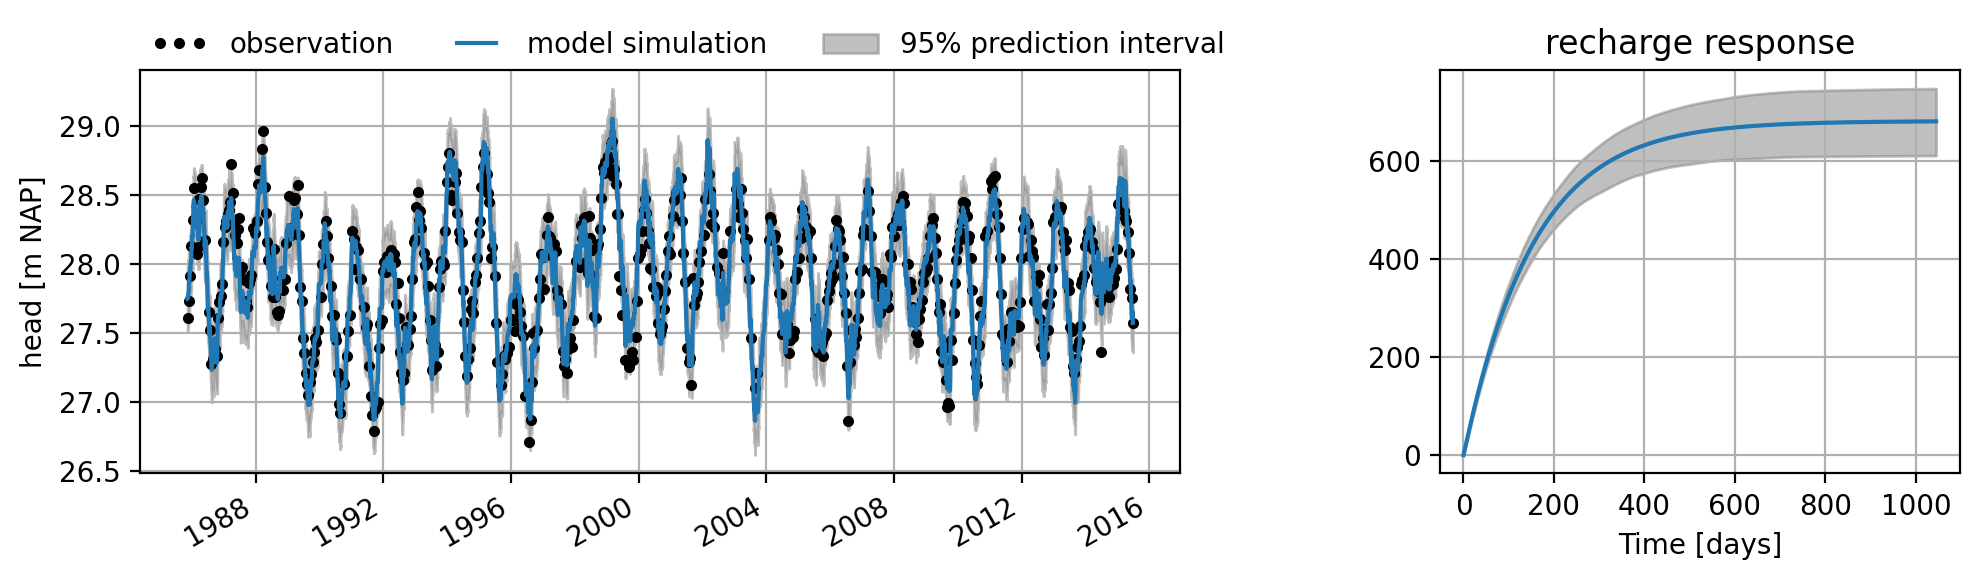

In [16]:
df = ml1.fit.prediction_interval()
fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
obs = ml1.oseries.series_original
sim = ml1.simulate()

obs.plot(ax=ax1, linestyle='', marker='.', color='k', label='observation', x_compat=True)

sim.plot(ax=ax1, x_compat=True, label='model simulation')

ax1.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% prediction interval")

ax1.set_ylabel('head [m NAP]')
ax1.grid()
ax1.legend(loc=(0, 1), ncol=3, frameon=False, numpoints=3)
ax2 = fig.add_subplot(gs[0, 1])

df = ml1.fit.ci_step_response("recharge", alpha=0.05, n=1000)

rch_response = ml1.get_step_response("recharge", add_0=True)


rch_response.plot(ax=ax2)
ax2.fill_between(df.index, df.iloc[:, 0], df.iloc[:, 1], color="gray",
                 zorder=-1, alpha=0.5, label="95% confidence")

ax2.grid()
ax2.set_xlabel("Time [days]")
ax2.set_title('recharge response')
plt.tight_layout()


<hr>

### Condition 1: Autocorrelation

Autocorrelation is the correlation of a time series with a time-shifted version of itself. If significant autocorrelation is still present in the noise, the confidence interval of the parameter will be underestimated (see the [Notebook on model calibration](%%) for an example). This type of correlation can be visualized in an autocorrelation plot. In this plot, the horizontal axis shows the time shift (also called 'lag'), and the vertical axis shows the calculated correlation.

The time shifts (lags) must correspond to the time step of the model. If the model uses daily time steps, the series must also be shifted by (multiples of) that time step to determine and evaluate the autocorrelation [(Collenteur, 2018)](#References).

<hr>

#### Example Autocorrelation Plot

Autocorrelation has been calculated for the example model, both with and without a noise model. The results are shown in the figures below. The maximum calculated lag is 365 days. A correlation was not calculated for every lag because the time series we are analyzing contains measurements approximately every 14 days.

The blue band in the plot represents the 95% confidence interval of the calculated autocorrelation. If the autocorrelation at a given lag falls within the 95% confidence interval, it can be stated with 95% certainty that the autocorrelation at that lag is zero. It is clearly visible that the residuals from the model without a noise model do not meet the autocorrelation requirement. Therefore, the calculated confidence interval for the parameters will not be accurate. In the model with a noise model, we see that there is no significant autocorrelation present in the noise.


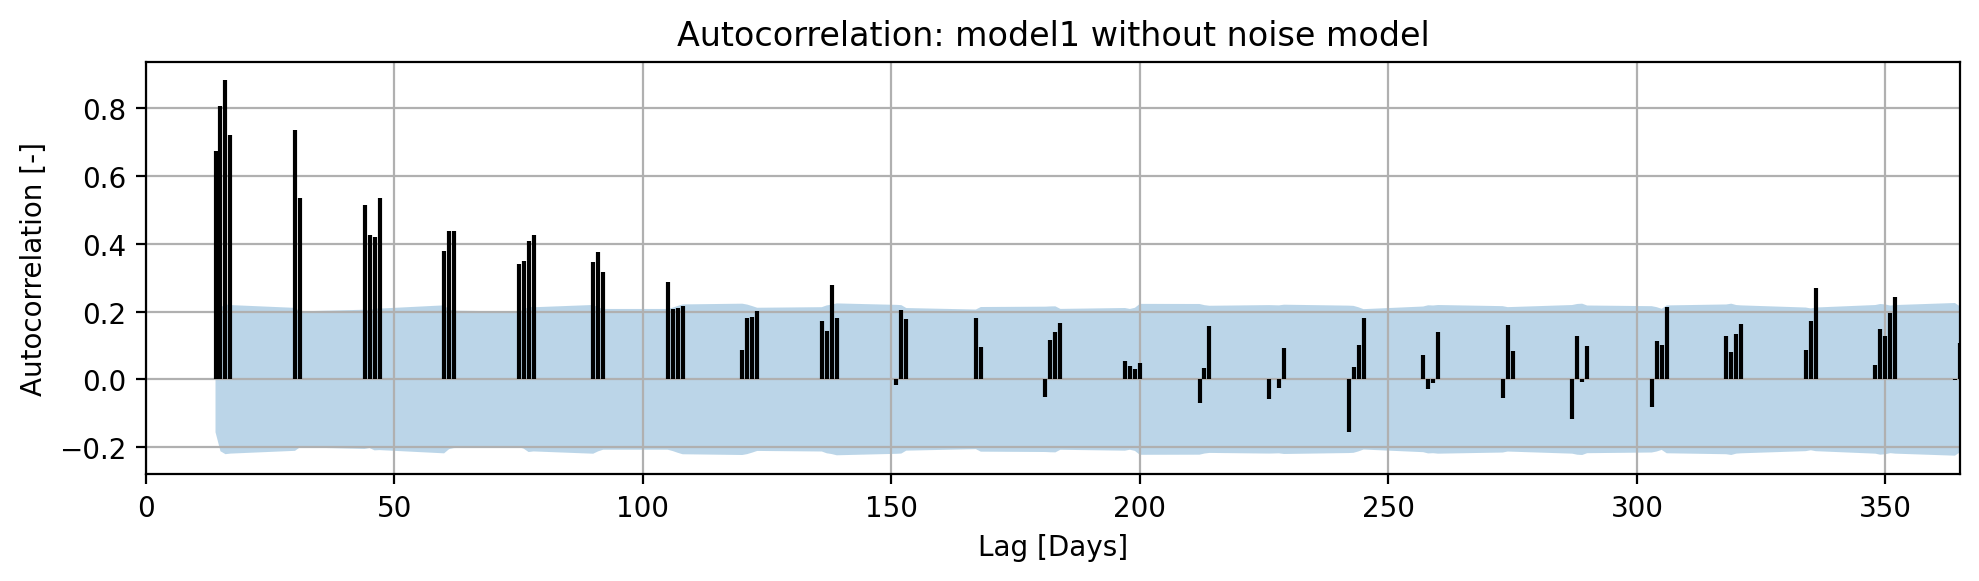

In [17]:
ml1.solve(report=False)
ax = ps.plots.acf(ml1.residuals(), figsize=(10, 3), alpha=0.05)
ax.set_title("Autocorrelation: model1 without noise model")
plt.tight_layout()
ylim = ax.get_ylim()

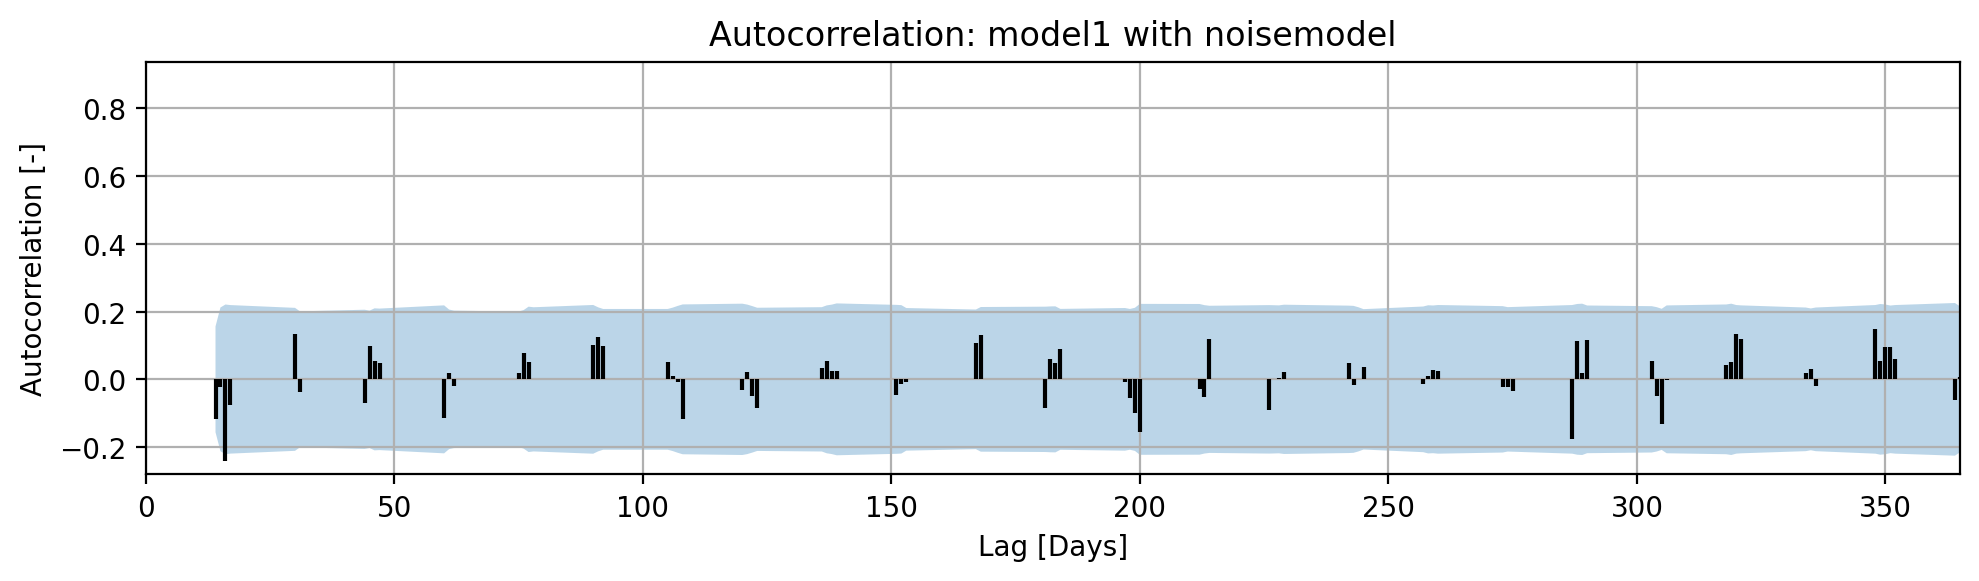

In [18]:
ml1.add_noisemodel(ps.ArNoiseModel())
ml1.solve(report=False)
ax = ps.plots.acf(ml1.noise(), figsize=(10, 3), alpha=0.05)
ax.set_ylim(ylim)
ax.set_title("Autocorrelation: model1 with noisemodel")
plt.tight_layout()

### Condition 2: Normal Distribution of Noise

Another requirement for white noise is that it follows a statistical distribution, preferably a normal distribution. The distribution of the noise can be visualized using a histogram combined with a normal probability distribution. This can be assessed visually by creating a histogram of the residuals/noise and comparing it with a normal distribution with $\mu$ equal to the mean of the noise and $\sigma$ equal to the standard deviation of the noise.

<hr>

#### Example: Visualizing the Normal Distribution of Noise

For the example model, a histogram of the noise has been plotted and compared with the normal distribution. This is shown in the left-hand graph. In the right-hand graph, the same analysis is presented in a different way — a so-called "probability plot". If the blue points lie on the black straight line, the noise is normally distributed.

Based on these results, it is estimated that the distribution of the noise approximates the normal distribution well enough to approve the model on this aspect.

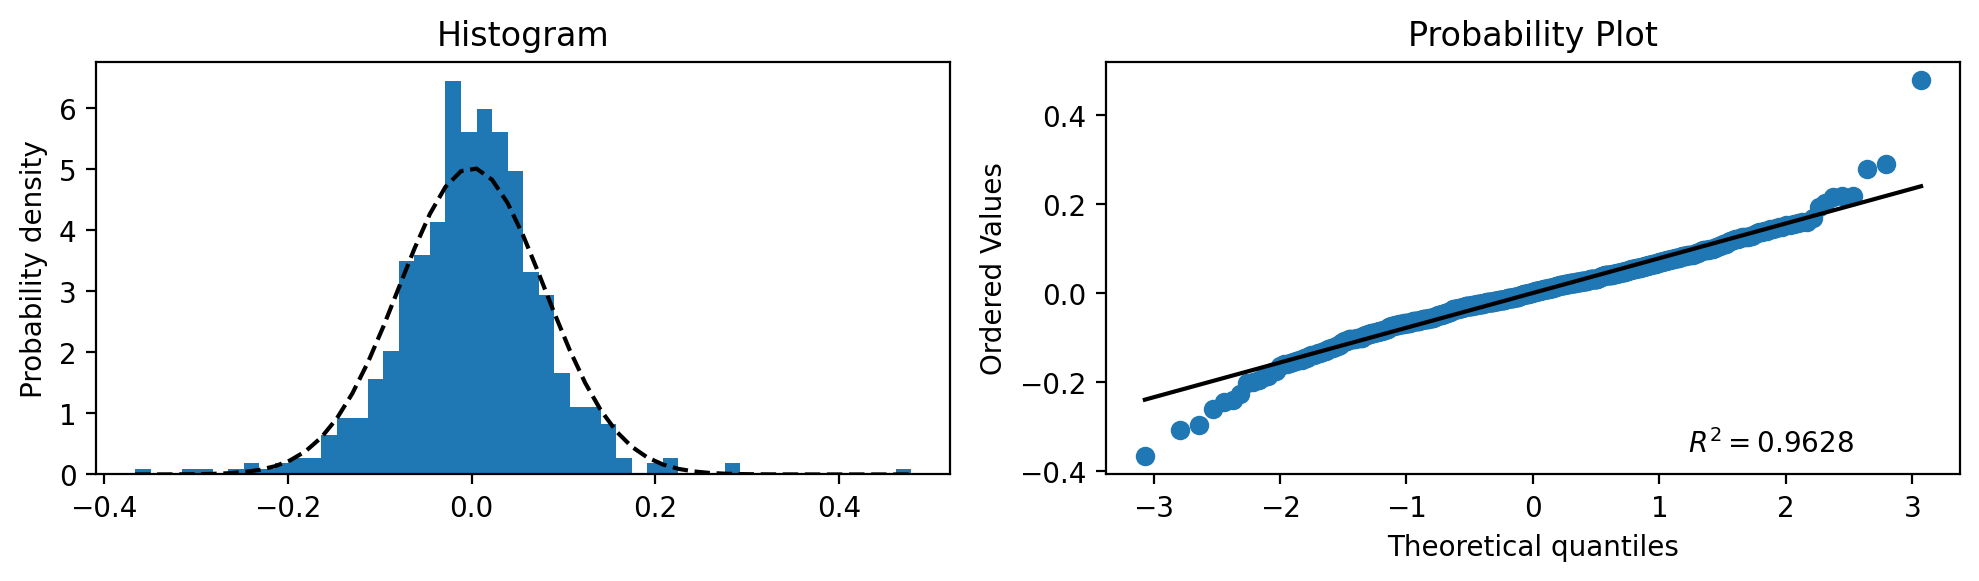

In [19]:
# Plot the histogram for normality and add a 'best fit' line
bins = 50
series = ml1.noise()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
_, bins, _ = ax1.hist(series.values, bins=bins, density=True)
y = norm.pdf(bins, series.mean(), series.std())
ax1.plot(bins, y, 'k--')
ax1.set_ylabel("Probability density")
ax1.set_title("Histogram")


# Plot the probability plot
probplot(series, plot=ax2, dist="norm", rvalue=True)
ax2.get_lines()[0].set_color('C0')
ax2.get_lines()[1].set_color("k")
plt.tight_layout()


### Condition 3: Homoscedasticity

The third statistical requirement for white noise is that the noise must be homoscedastic. A time series is homoscedastic when the variance is independent. One way to assess this is by examining the absolute values of the series. If the noise is not homoscedastic (i.e., heteroscedastic), the variance of the noise depends on the groundwater head. This can be visually assessed by plotting the noise against the groundwater head measurements.

If the spread of the noise is not consistent across the full range of groundwater head measurements, the noise is heteroscedastic. However, this does not automatically confirm that the noise is homoscedastic. The variance of the noise may also be correlated in other ways, for example, over time.

<hr>

#### Example: Visualizing Homoscedasticity

For example model 1, the noise has been plotted against the observations. The spread of the noise appears to be fairly constant across the range of groundwater head measurements. Based on the absolute values, the noise therefore appears to be homoscedastic.


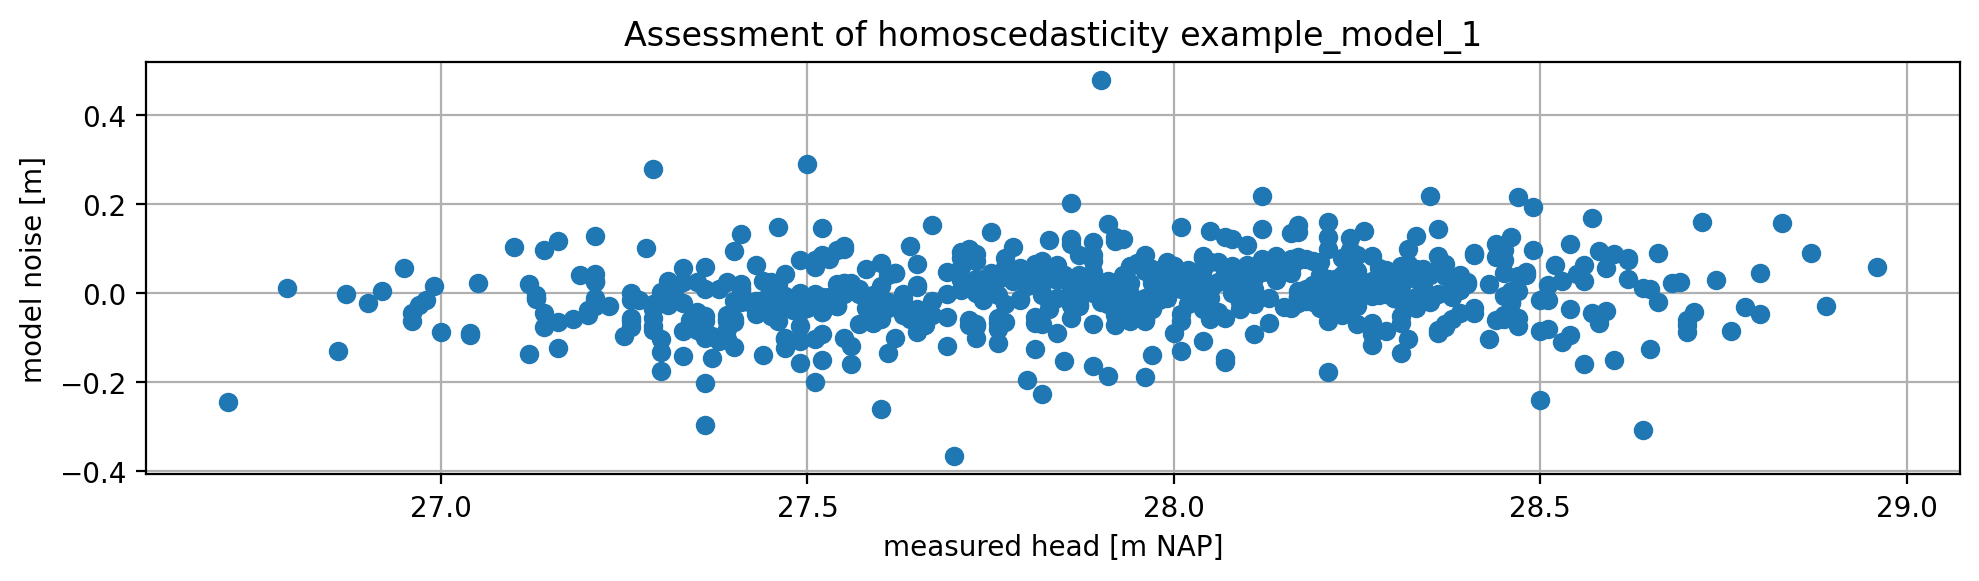

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(ml1.observations(), ml1.noise(), marker="o", linestyle=" ")
ax.set_xlabel("measured head [m NAP]")
ax.set_ylabel("model noise [m]")
ax.set_title("Assessment of homoscedasticity example_model_1")
ax.grid()
plt.tight_layout()

### Condition 4: Correlation of Noise with Explanatory Time Series

The final requirement regarding the noise is that it must not be significantly correlated with any of the explanatory series in the time series model. If it is, this indicates that the response function used is apparently not capable of fully describing the behavior of the groundwater head based on the explanatory series. In that case, the uncertainty of the parameters cannot be accurately determined, and the model structure needs to be adjusted.

<hr>

## Hydrological Assessment<a id='hydrologisch-beoordeling'></a>

Time series models are widely used for system identification, where the contributions of different influences to changes in groundwater head are estimated. In practice, time series analysis is often applied to an entire monitoring network or to multiple observation wells within an area of interest. Performing a hydrological assessment of individual models, as well as entire sets of time series models, is useful for gaining deeper insight into the system.


### Hydrology<a id='hydrologie'></a>

Assessing models based on hydrological aspects can take many forms. The key questions are: "Does the system behave the way I think it does?" and "Are the results I calculate hydrologically plausible?" In this context, models that do meet expectations are just as interesting as those that do not. For example, consider a model with groundwater recharge and an abstraction rate as explanatory variables. A simple first hydrological assessment is to check whether the groundwater head increases when it rains and decreases when groundwater is extracted. If that is not the case, there is a high chance that the model is not reliable.

Time series models can be assessed based on hydrology, but conversely, the model results can also enhance hydrological understanding of the system.

<hr>

#### Example: Hydrological Assessment

As an example of a hydrological assessment of a time series model, the response to a groundwater abstraction is considered. In the figure below, two different step responses are shown with an uncertainty band. The band, equal to 2 times the standard deviation, is calculated here based on the uncertainty in the gain parameter (the parameter that determines the steady-state effect of the abstraction). In the left-hand graph, the uncertainty of the step response is small—in other words, the parameters can be determined relatively accurately during optimization. In the right-hand graph, this uncertainty is much larger, meaning the influence of the abstraction cannot be estimated accurately through optimization. Note that in this example, a positive step response indicates that the abstraction causes a decrease in groundwater head.

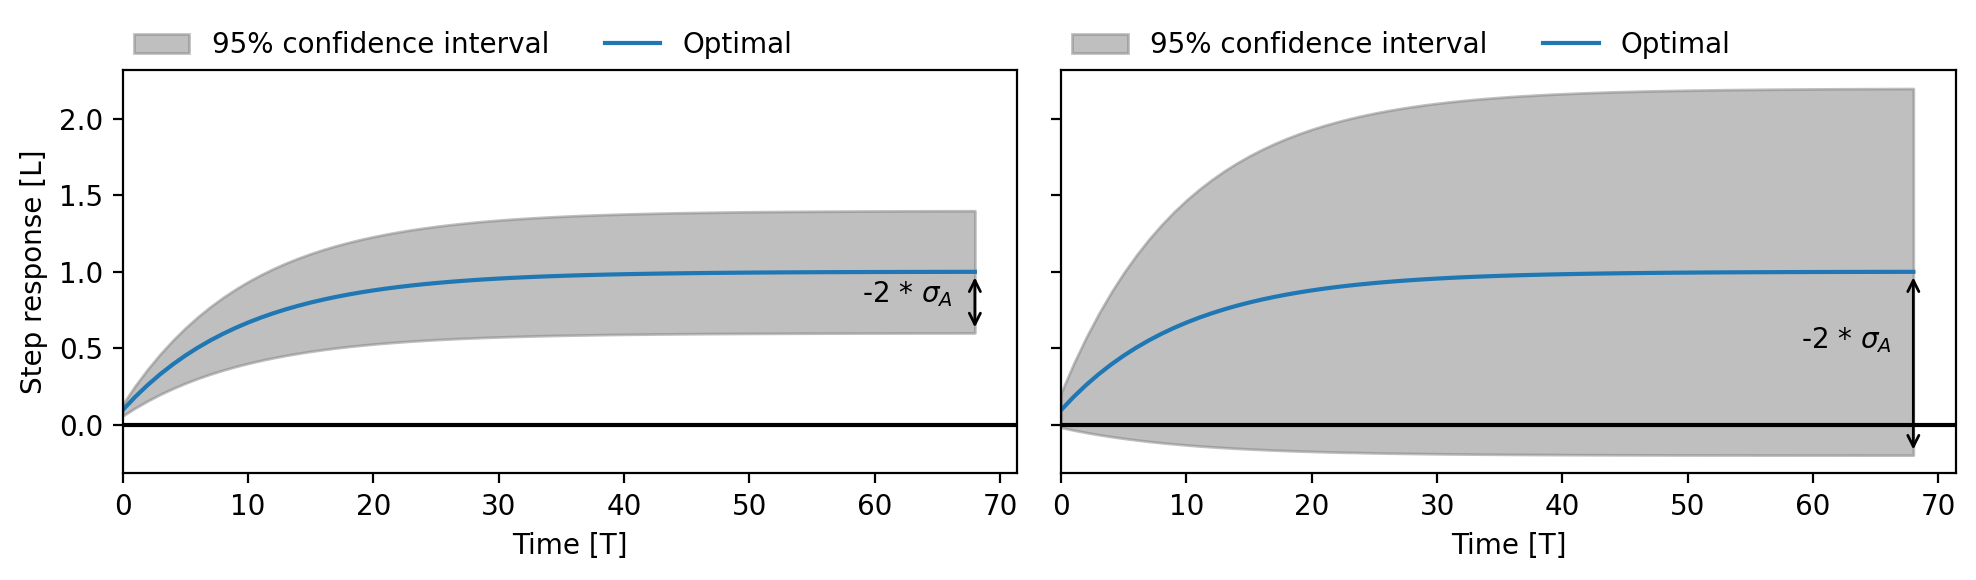

In [21]:

rfunc = ps.Gamma()
p = rfunc.get_init_parameters("")


b = rfunc.step(p=p.initial.values)
b1 = rfunc.step(p=[1.4, 1, 10])
b2 = rfunc.step(p=[0.6, 1, 10])
t = np.arange(len(b))

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 3))


# Plot Links
ax[0].fill_between(t, b2, b1, color='gray', alpha=0.5,
                   label='95% confidence interval')
ax[0].plot(b, label="Optimal")
ax[0].axhline(0, c='k')
ax[0].legend(loc=(0, 1), frameon=False, ncol=2)
ax[0].set_xlim(0)
ax[0].set_xlabel("Time [T]")
ax[0].set_ylabel("Step response [L]")
ax[0].annotate('', xy=(t[-1], b[-1]), xycoords='data', xytext=(t[-1], b2[-1]),
               textcoords='data', arrowprops={'arrowstyle': '<->'})
ax[0].annotate('-2 * $\sigma_A$', xy=(t[-10], 0.8), xycoords='data',
               xytext=(0, 0), textcoords='offset points')


b1 = rfunc.step(p=[2.2, 1, 10])
b2 = rfunc.step(p=[-0.2, 1, 10])
ax[1].fill_between(t, b2, b1, color='gray', alpha=0.5,
                   label='95% confidence interval')
ax[1].plot(b, label="Optimal")
ax[1].axhline(0, c='k')
ax[1].legend(loc=(0, 1), frameon=False, ncol=2)
ax[1].set_xlabel("Time [T]")
ax[1].set_xlim(0)
ax[1].annotate('', xy=(t[-1], b[-1]), xycoords='data', xytext=(t[-1], b2[-1]),
               textcoords='data', arrowprops={'arrowstyle': '<->'})
ax[1].annotate('-2 * $\sigma_A$', xy=(t[-10], 0.5), xycoords='data',
               xytext=(0, 0), textcoords='offset points')

plt.tight_layout()

*Estimated step response of an abstraction with low uncertainty (left) and high uncertainty (right).*

From a hydrological perspective, the abstraction should cause a decrease in groundwater head. However, in the case of the uncertain model (right), there is more than a 5% chance that the abstraction causes an increase in groundwater head. The uncertainty band is large enough that the step response could also be negative. In that case, we can conclude that this is not hydrologically plausible. The abstraction may not have a significant influence on the groundwater head.

<hr>

### Response Memory

A response function provides insight into, among other things, the delay with which the groundwater head adjusts to a change in an explanatory variable. A simple example is how long an increase in groundwater head persists after a rainfall event. The time it takes for the effect of a change in an explanatory variable on the groundwater head to become negligibly small is often referred to as the memory of the response.

If the response memory is longer than the length of the time series on which the time series model is calibrated, then the time series is not long enough to accurately estimate such a delayed response. In that case, the time series model could be rejected on that basis.

Another way to assess the memory of the response is from a hydrological perspective. Based on hydrological system knowledge, it may be possible to define limits for the expected memory of the response, or by comparing multiple models, it can be evaluated whether the response memory is plausible. This latter example is a form of spatial assessment, which is discussed later in this notebook.

<hr>

#### Example: Determining the Memory of the Response Function

The memory of the response function cannot be determined by identifying the point where the response equals zero. Most response functions never actually reach zero but instead approach zero as $t \rightarrow \infty$. For this reason, a common measure of memory is the time it takes for 95% of the response to dissipate. This is visualized below.

Memory (t_95) = 456 days


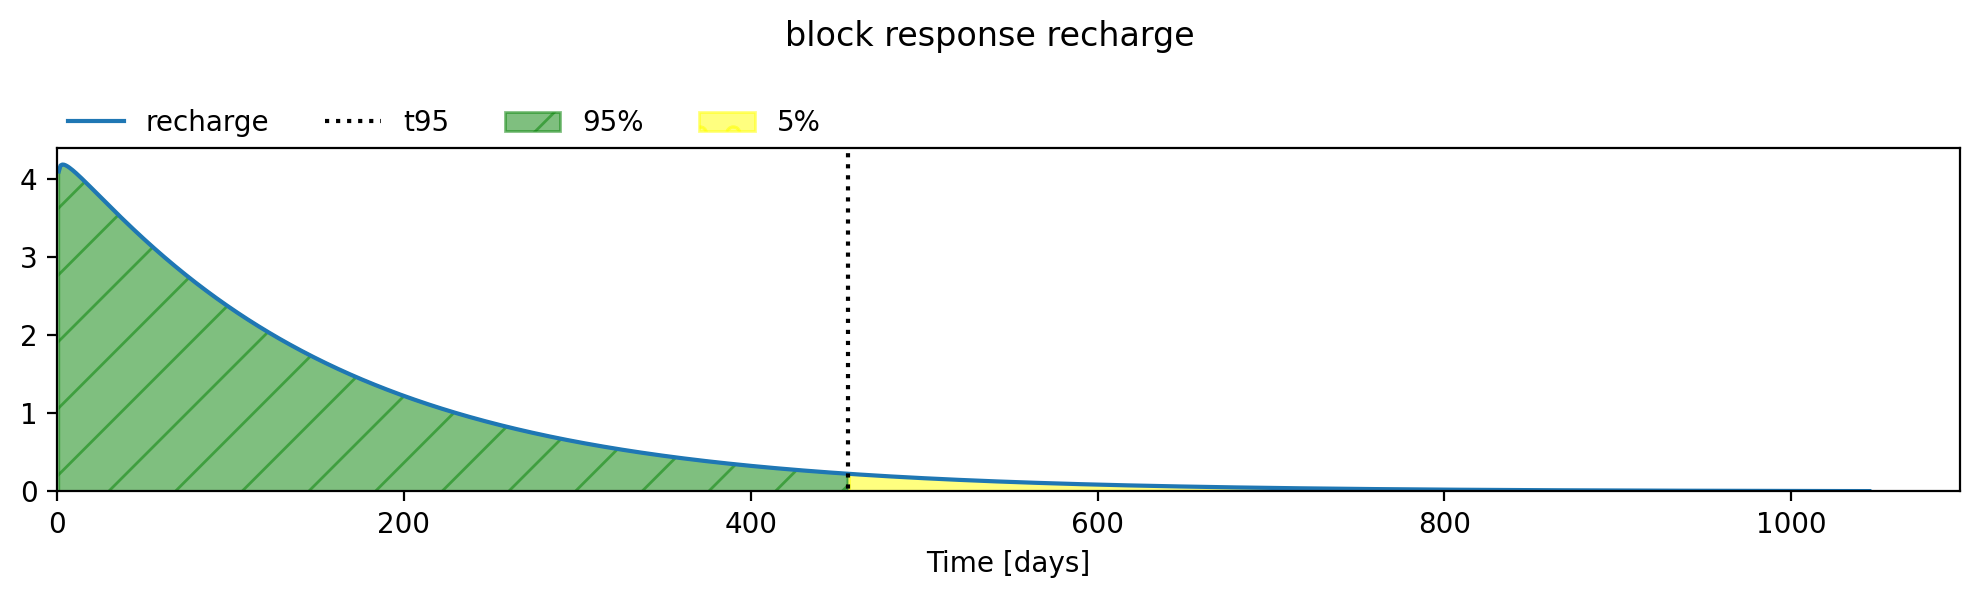

In [22]:
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
t95 = resp_func.get_tmax(ml1.get_parameters('recharge'), cutoff=0.95)
print(f'Memory (t_95) = {t95:.0f} days')

ax = ml1.plots.block_response(figsize=(10, 3))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='k', label='t95', lw=1.5)

block_response = sm.rfunc.block(ml1.get_parameters('recharge'))

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                hatch='/', where=range(len(block_response)) < t95,
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(1, len(block_response)+1), 0, block_response,
                where=range(len(block_response)) > t95, hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend(loc=(0, 1), frameon=False, ncol=4)
ax.figure.suptitle('block response recharge')
plt.tight_layout()


<hr>

#### Example: Memory 1

Below, the block response and model results of the example model are plotted in a single figure. In this model, the length of the time series is several times longer than the memory of the response function. Therefore, we can conclude that the time series is sufficiently long to estimate the response.

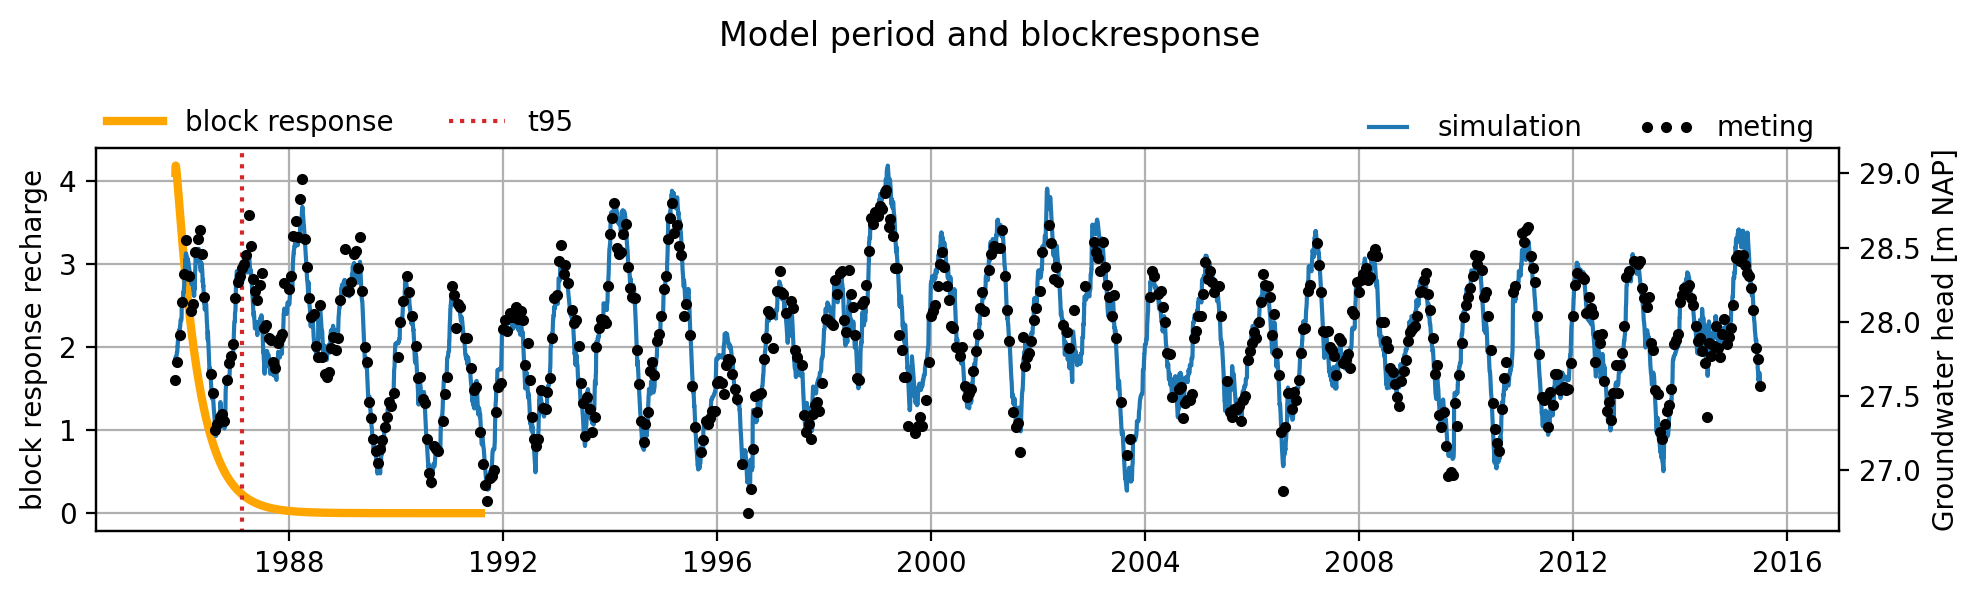

In [23]:
# get response function
sm = ml1.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 3))
block_resp = resp_func.block(
    ml1.get_parameters('recharge'), cutoff=0.999999)

# plot response function
ax.plot(pd.date_range(ml1.settings['tmin'], periods=len(block_resp)),
        block_resp, label='block response', color='orange', lw=3)
ax.grid()
ax.set_ylabel('block response recharge')
# ax.set_ylim(0,6)


# plot t95 response functie
t95 = ml1.stressmodels['recharge'].rfunc.get_tmax(
    ml1.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml1.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=1.5)
ax.set_ylim(ylim)
ax.legend(loc=(0, 1), frameon=False, ncol=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml1.simulate(), label='simulation')  # , lw=0.2)
ax2.plot(ml1.oseries.series_original[:],
         marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('Groundwater head [m NAP]')
# ax2.set_ylim(28,31)
ax2.legend(bbox_to_anchor=(1, 0.95), loc="lower right",
           ncol=2, frameon=False, numpoints=3)

fig.suptitle('Model period and blockresponse')
plt.tight_layout()

<hr>

#### Example: Memory 2

For another example model, the block response and model results are also plotted in a single figure. In this model, the length of the time series is shorter than the memory of the response function. If the response is longer than the measurement series, it cannot be determined from the data whether the response is justifiably that long. In this case, it can be concluded that the time series is not long enough to derive a reliable time series model.

In [24]:
head = pd.read_csv("data/hds_vb_geheugen.csv", parse_dates=True, index_col=0)
head = head.iloc[:, 0]  

rech = pd.read_csv("data/recharge_vb_geheugen.csv", parse_dates=True, index_col=0)
rech = rech.iloc[:, 0]

head.name = "groundwater head"
rech.name = "recharge"

ml_example = ps.Model(head, name='B52C0508-002')
sm = ps.StressModel(rech, rfunc=ps.Gamma(), name="recharge", settings = "prec")
ml_example.add_stressmodel(sm)
ml_example.add_noisemodel(ps.ArNoiseModel())
ml_example.solve(report=False, fit_constant=True)

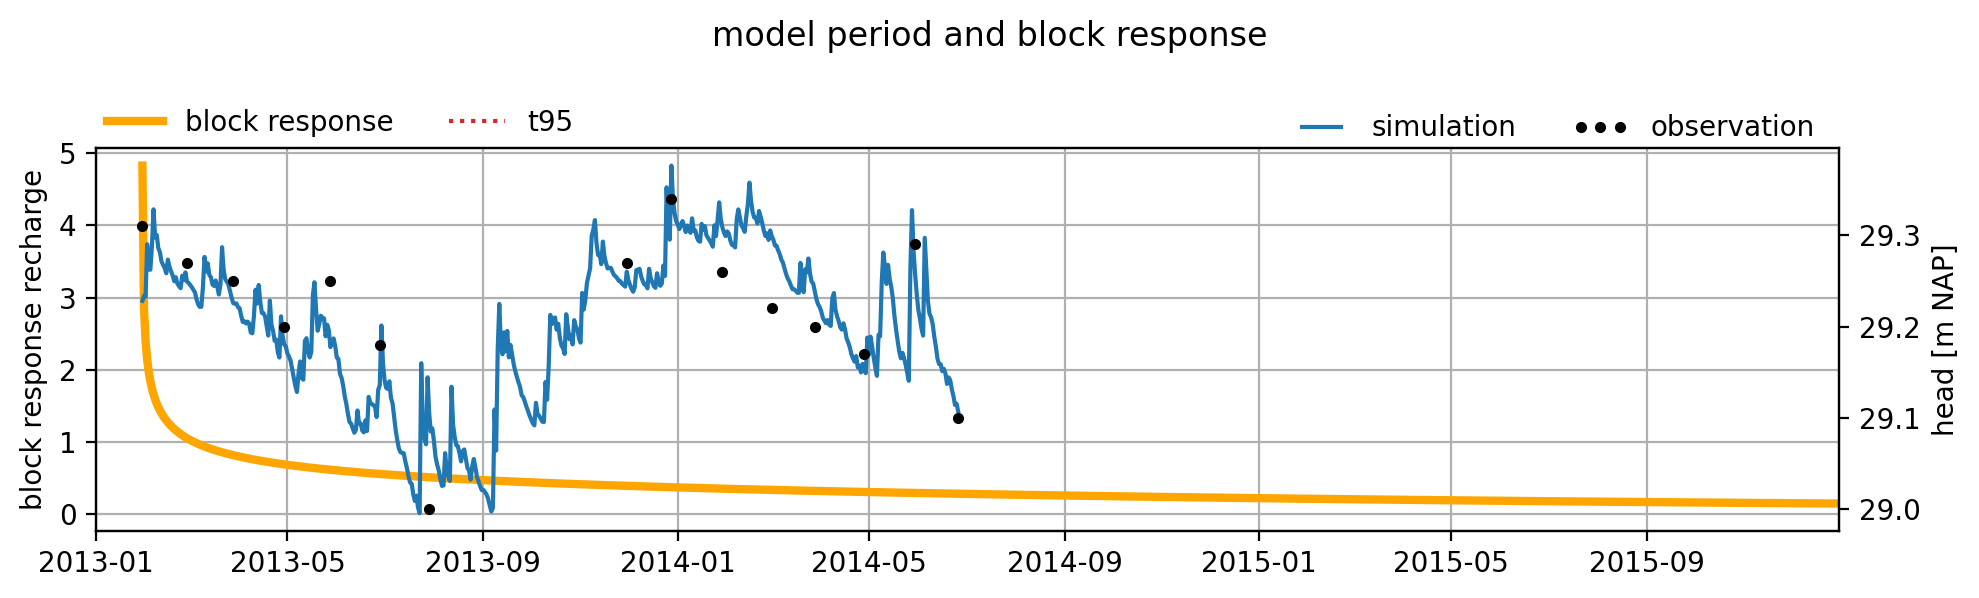

In [25]:
# get response function
sm = ml_example.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(10, 3))
block_resp = resp_func.block(
    ml_example.get_parameters('recharge'), cutoff=0.97)

# plot response function
ax.plot(pd.date_range(ml_example.settings['tmin'], periods=len(block_resp)),
        block_resp, label='block response', color='orange', lw=3)
ax.grid()
ax.set_ylabel('block response recharge')

# plot t95 of the response function
t95 = ml_example.stressmodels['recharge'].rfunc.get_tmax(
    ml_example.get_parameters('recharge'), cutoff=0.95)
t95_dt = ml_example.settings['tmin'] + dt.timedelta(t95)
ylim = ax.get_ylim()
ax.vlines(t95_dt, -100, 100, ls=':', color='C3', label='t95', lw=1.5)
ax.set_ylim(ylim)
ax.legend(loc=(0, 1), frameon=False, ncol=2)
ax.set_xlim(pd.Timestamp("2013-01-01"), pd.Timestamp("2015-12-31"))

# plot model results
ax2 = ax.twinx()
ax2.plot(ml_example.simulate(), label='simulation')
ax2.plot(ml_example.oseries.series_original,
         marker='.', ls='', color='k', label='observation')
ax2.set_ylabel('head [m NAP]')
ax2.legend(bbox_to_anchor=(1, 0.95), loc="lower right",
           ncol=2, frameon=False, numpoints=3)
ax2.set_xlim(pd.Timestamp("2013-01-01"), pd.Timestamp("2015-12-31"))

fig.suptitle('model period and block response')
plt.tight_layout()

<hr>

### Net Precipitation

The influence of precipitation and evaporation is often incorporated as the net precipitation, calculated using the following formula:

$$ \text{R} = \text{P} + f \cdot \text{E}$$

where $\text{R}$ is the net precipitation, $\text{P}$ is the precipitation, and $\text{E}$ is the evaporation. In the Netherlands, reference crop evaporation is commonly used as a measure of potential evaporation. The actual evaporation, i.e., how much actually evaporates, is usually unknown. In the formula above, the actual evaporation is calculated by multiplying the potential evaporation by the evaporation factor $f$. The evaporation factor is often optimized within a time series model.

The optimized value of the evaporation factor can be evaluated from a hydrological perspective. The following interpretations can be given to the optimized value:

- $f < -2$: the net precipitation is calculated using an actual evaporation that is more than twice the reference crop evaporation.
- $-2 < f < 0$: the net precipitation is calculated by scaling the evaporation by a certain factor.
- $f = 0$: the precipitation alone is sufficient to explain the groundwater head. Evaporation is not included in the time series model.
- $f > 0$: the evaporation factor is positive, which would mean that evaporation leads to a rise in the groundwater head. This is not hydrologically plausible.

In addition to evaluating the optimized value, it is also possible to define boundary values within which a given parameter may be optimized. This allows physical constraints to be imposed on the model. For the evaporation factor, the following bounds are often applied:
- $f < 0$: evaporation should result in a decrease in groundwater head, so the evaporation factor must be less than zero.
- $f > -2$: the actual evaporation used in the net precipitation calculation must not be more than twice the reference crop evaporation. Reference crop evaporation is based on a well-watered and well-nourished crop, so it is illogical for actual evaporation to be more than twice that amount.


#### Evaporation Factor and Crop Coefficient

In many groundwater models, a crop coefficient is used to convert reference crop evaporation into actual evaporation. This coefficient is often compared to the evaporation factor used in time series models. While there are certainly similarities between the two, there are also some important differences:

- The evaporation factor in a time series model is optimized together with other parameters. It can be correlated with other model parameters. For example, a slightly overestimated drainage base might be compensated by a lower evaporation factor. As a result, the optimized value of the evaporation factor only has meaning in combination with the other model parameters and cannot be directly compared to a physical crop coefficient.

- The actual evaporation (or transpiration) of a crop varies significantly throughout the year, depending on the season and the crop's growth characteristics. Therefore, the crop coefficient is not constant. In many time series models, however, the evaporation factor is assumed to be constant.


<hr>

#### Example: Evaporation Factor

The time series from the base model were used to illustrate the effect of the evaporation factor on the model results. First, the net precipitation is shown for different evaporation factors. Below that, the model results are displayed for the same model, each time optimized with a different fixed value for the evaporation factor.

Several observations can be made from the graphs:
- With an evaporation factor of $f = 0$, evaporation is not included; the model is optimized solely based on precipitation. The fit between the modeled and observed groundwater heads is poor.
- With an evaporation factor of $f = -1.3$, the best fit is achieved. This is the optimal value of the evaporation factor from the original model.
- With an evaporation factor of $f = -2.0$, evaporation weighs twice as heavily as precipitation, and the fit between the model simulation and the measurements is still quite good.
- With an unrealistic evaporation factor of $f = -10.0$, evaporation weighs ten times more than precipitation. Because the actual evaporation is extremely overestimated, the effect of precipitation is barely visible in the simulated series.

Finally, for all models, the optimized drainage base is also shown. A correlation with the evaporation factor can be observed: when the evaporation factor is fixed at a lower value during optimization, this is compensated by a higher drainage base.

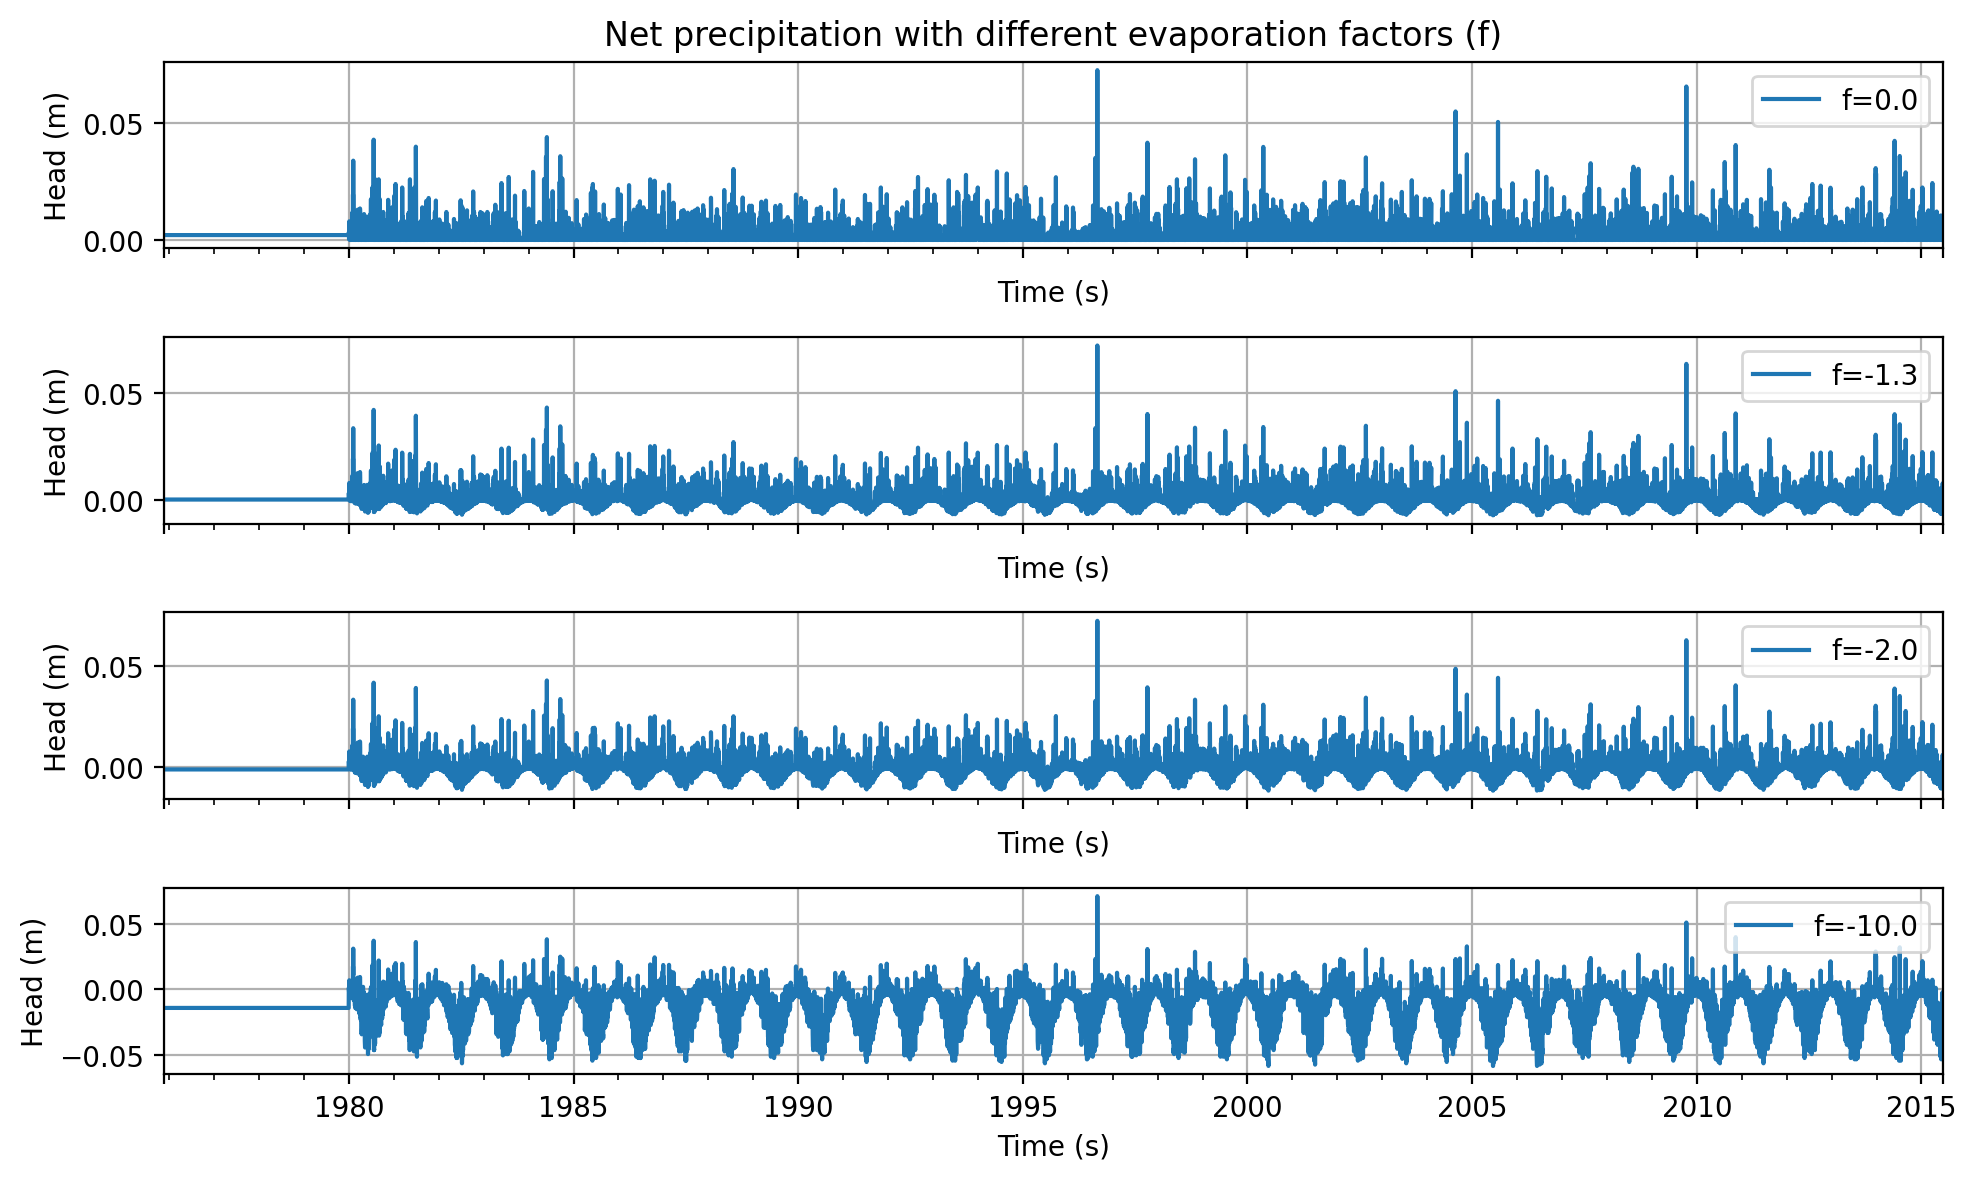

In [26]:
# sla optimale verdampingsfactor op
f_opt = ml1.parameters.loc["recharge_f", "optimal"]

neerslag, verdamping = ml1.stressmodels['recharge'].stress

# berekenen en plotten verdampingsfactoren
verdampingsfactoren = [
    1e-10, ml1.parameters.loc['recharge_f', 'optimal'], -2.0, -10.0]

fig, ax_list = plt.subplots(figsize=(10, 6), nrows=len(verdampingsfactoren))
for i, f in enumerate(verdampingsfactoren):
    neerslagoverschot = neerslag.series + f * verdamping.series
    neerslagoverschot.plot(ax=ax_list[i], label=f'f={f:.1f}')
    ax_list[i].grid()
    ax_list[i].legend(loc=1)
    ax_list[i].set_ylabel("Head (m)")
    ax_list[i].set_xlabel("Time (s)")
    if i != len(verdampingsfactoren)-1:
        ax_list[i].set_xticklabels([])
ax_list[0].set_title(
    'Net precipitation with different evaporation factors (f)')
plt.tight_layout()

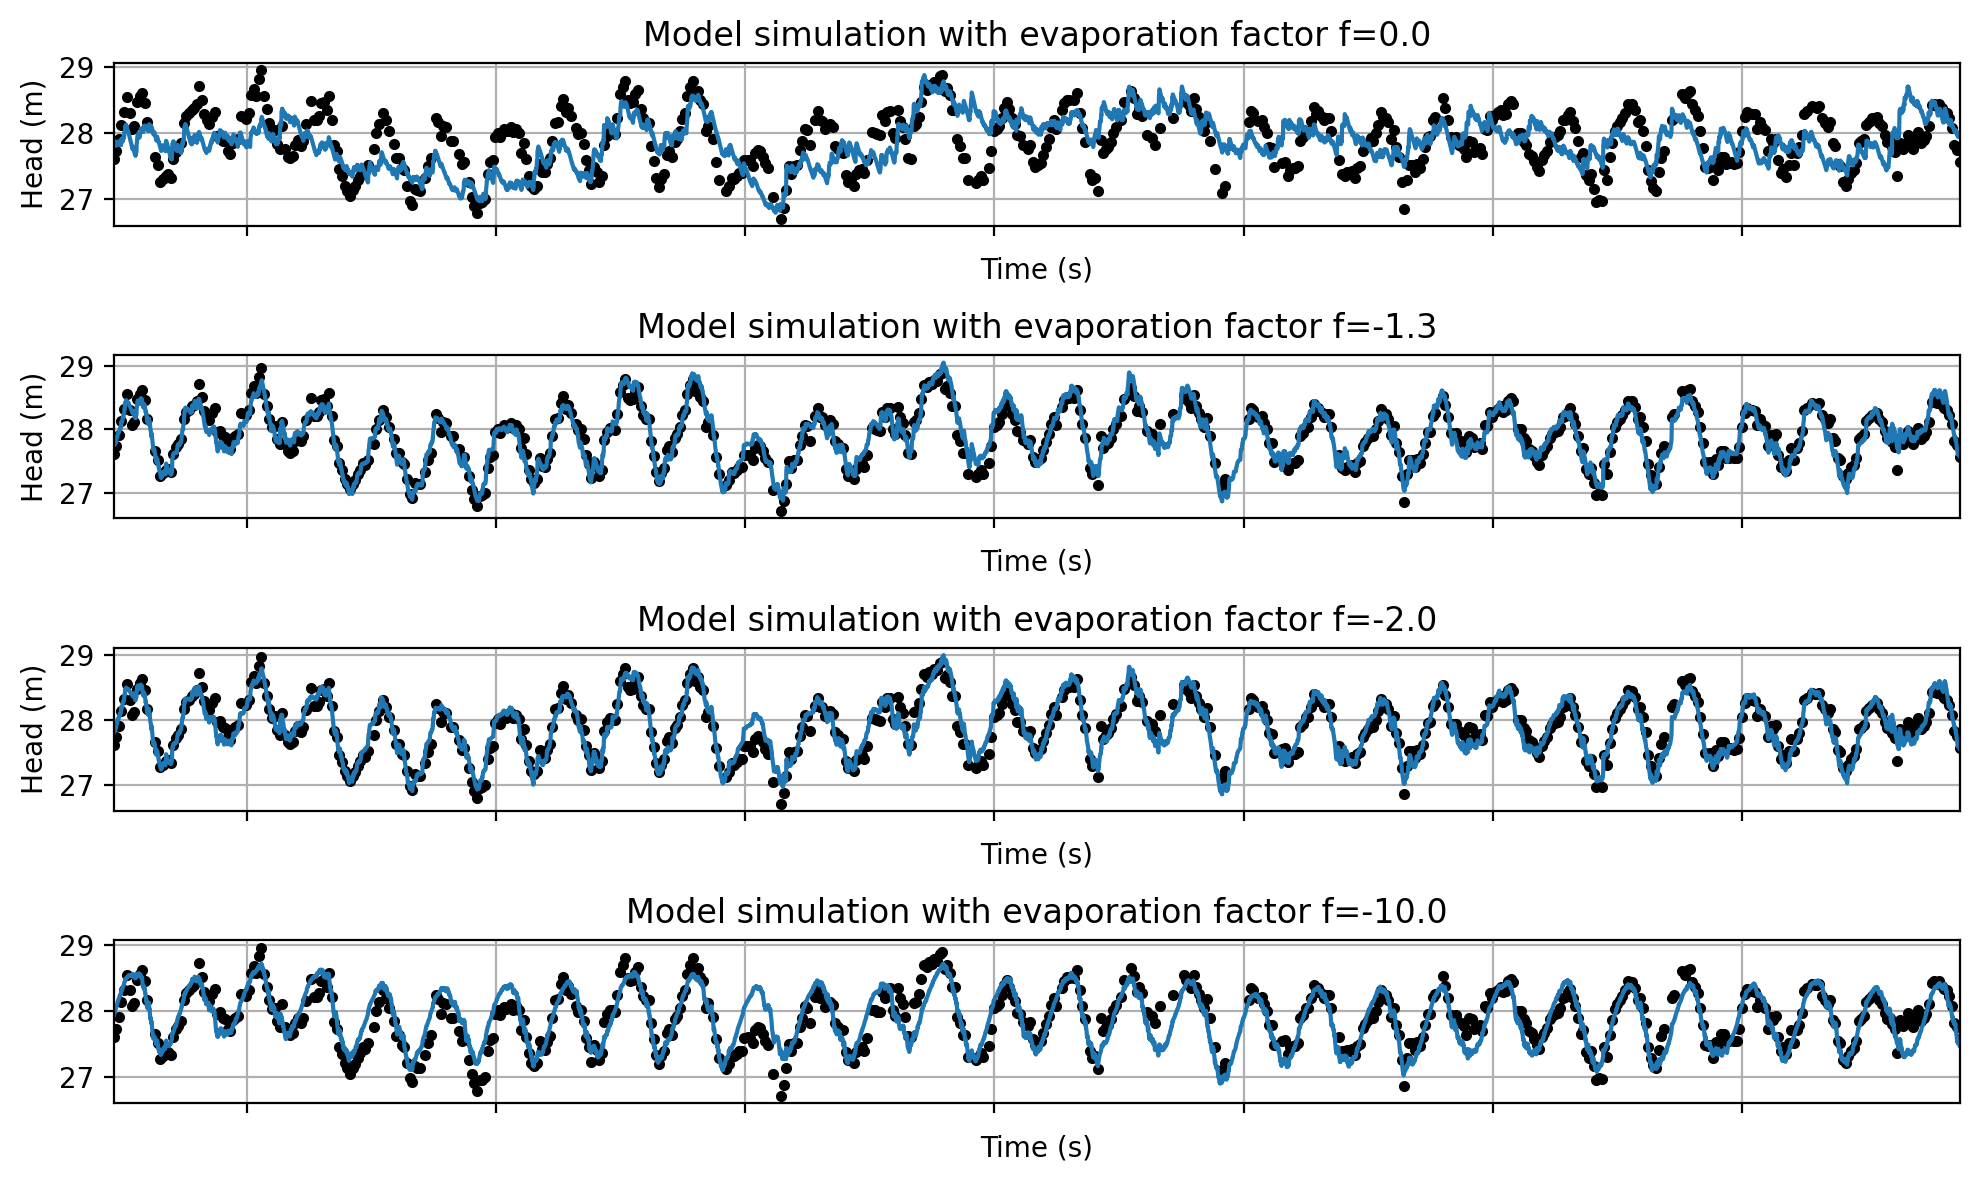

In [29]:
neerslag, verdamping = ml1.stressmodels['recharge'].stress

# berekenen en plotten verdampingsfactoren
verdampingsfactoren = [1e-10, f_opt, -2.0, -10.0]

fig, ax_list = plt.subplots(figsize=(10, 6), nrows=len(verdampingsfactoren))
results_df = pd.DataFrame(index=verdampingsfactoren,
                          columns=['drainagebasis (m NAP)', 'EVP (%)'])

for i, f in enumerate(verdampingsfactoren):
    ml1.set_parameter('recharge_f', initial=f, vary=False)
    ml1.parameters.loc["recharge_f", "optimal"] = f
    ml1.solve(report=False)
    ml1.plot(ax=ax_list[i], label=f'f={f:.1f}', legend=False)
    ax_list[i].set_ylabel("")
    ax_list[i].grid()
    if i != 4:
        ax_list[i].set_xticklabels([])
    results_df.loc[f, 'drainagebasis (m NAP)'] = \
        f'{ml1.parameters.loc["constant_d", "optimal"]:.2f}'
    results_df.loc[f, 'EVP (%)'] = f'{ml1.stats.evp():.2f}'

    ax_list[i].set_title(f'Model simulation with evaporation factor f={f:.1f}')
#     print(f'modelsimulatie met verdampingsfactor f={f:.1f} heeft een '
#           f'geoptimaliseerde drainagebasis van '
#           f'{ml1.parameters.loc["constant_d", "optimal"]:.2f} m')
    ax_list[i].set_ylabel("Head (m)")
    ax_list[i].set_xlabel("Time (s)")
results_df.index = [f'{i:.1f}' for i in ([0] + verdampingsfactoren[1:])]
results_df.index.name = 'verdampingsfactor'
ax_list[-1].set_xlim(ax_list[-2].get_xlim())
ax_list[-1].set_ylabel('')
plt.tight_layout()

<hr>

#### Parameter Correlation

When optimizing time series models, it is also possible to examine the correlations between parameters. If a model contains parameters that are 100% correlated, a change in one parameter can be compensated by a change in the correlated parameter, while the model fit remains virtually the same. High parameter correlation is not a problem for the reliability of the time series model. After all, the model always uses the combination of these parameters to perform a simulation. However, high correlations mean that the absolute value of the optimized parameter should not be considered independently of the absolute value of the correlated parameter.


<hr>

#### Example: Parameter Correlations

The evaporation factor and the drainage base are parameters that are often strongly correlated. In the model from the previous example, the correlation between the evaporation factor and the drainage base is -0.98. In the previous example, the models were each calculated using a different evaporation factor, and in the results of this model, we can clearly observe the effect of the high correlation with the drainage base. 

The table below shows the values of the evaporation factor, the optimized drainage base, and the NSE. It is clearly visible that as the evaporation factor increases, the optimized drainage base decreases. It is also apparent that the NSE decreases by only 1.5 percentage points compared to the optimal model when the evaporation factor is set to -2.0. The value of the drainage base increases to compensate for this increase in evaporation. In this case, the absolute values of the drainage base and the evaporation factor cannot be interpreted independently of one another.

In [28]:
results_df

,drainagebasis (m NAP),EVP (%)
verdampingsfactor,,
0.0,25.07,15.76
-1.3,27.88,92.91
-2.0,28.55,91.80
-10.0,30.36,76.76


<hr>

### Spatial Assessment

In many studies, time series analysis is applied to multiple groundwater head monitoring points. These studies may aim, for example, to determine where groundwater heads can be well explained by groundwater recharge, or to investigate the influence of a drinking water abstraction on groundwater levels—among many other possible objectives. In such studies, it is useful to perform a spatial assessment of the results. For examples of spatial analyses, see for instance [Baggelaar (1988)](#References), [Asmuth (2012)](#References), and [Berendrecht (2016)](#References). This aspect is illustrated in the following example.

<hr>

#### Example: Hydrological Spatial Assessment

An example of spatial assessment of time series models is provided by [Collenteur et al. (2019)](#References). In that study, time series models were developed for observation wells within a radius of ±5 km around a drinking water abstraction site operated by Brabant Water near Seppe. These time series models included precipitation, evaporation, and the abstraction rate of the Seppe site as explanatory variables. The models were then optimized.

In the figure below, the calculated steady-state influences (also known as the 'gain') of the Seppe abstraction are plotted against the distance between the observation wells and the abstraction location. A distinction is made between wells in the first and second aquifer layers. The vertical bars indicate the uncertainty, corresponding to twice the standard deviation of the parameter. The steady-state influence is calculated for an abstraction rate of 1 million m³/year. The figure also shows the theoretical steady-state influence of the abstraction as a function of distance, calculated with a two-layer analytical element groundwater model [(Bakker et al., 2003)](#References), serving as an additional check on the influence estimated by the time series models.

![drawdown_example](data/drawdown_screenshot.png)

*Calculated steady-state influence of the Seppe abstraction as a function of distance at an abstraction rate of 1 Mm³/year (source: Collenteur et al. (2019))*

Each time series model is independent of the others; each model estimates the contributions of precipitation, evaporation, and abstraction to changes in groundwater head based on local measurements. The calculated pattern of greater drawdown near the abstraction site aligns well with the theoretical influence of pumping. The difference between the first and second aquifer layers is also clearly visible in the time series model results. Moreover, the results show good agreement with those from a simple groundwater model.

These independent models appear to be well suited to estimate the influence of the drinking water abstraction on groundwater heads. Based on this spatial assessment, it is concluded that the time series models can be applied for further analysis of the abstraction’s impact. A spatial hydrological review of the results from multiple time series models can be a valuable part of the assessment.

## References

- Baggelaar, P.K. (1988) Tijdreeksanalyse bij verlagingsonderzoek: principe en voorbeeld. H$_2$O (21) nr. 15
- Bakker, M., and O.D.L. Strack (2003). Analytic Elements for Multiaquifer Flow. Journal of Hydrology, 271(1-4), 119-129.
- Berendrecht, W.L., and F.C. Van Geer (2016) A dynamic factor modeling framework for analyzing multiple groundwater head series simultaneously. Journay of Hydrology, Vol. 536, 50-60.
- Collenteur, R.A. (2018) Over autocorrelatie van tijdreeksmodellen met niet-equidistante tijdstappen, Artesia, Schoonhoven, Nederland.
- Collenteur, R.A., M. Bakker, R. Caljé, S.A. Klop, F. Schaars (2019) Pastas: Open Source Software for the Analysis of Groundwater Time Series. Groundwater, Vol. 57, No. 6, 877–885
- van Geer, F. (2012) Tijdreeksanalyse: Introductie en aandachtspunten. Stromingen 18, nummer 2.
- Jackson et al. (2019) Introductory overview: Error metrics for hydrological modelling - A review of common practices and an open source library to facilitate use and adoption. Environmental Modelling & Software 119, 32-48.
- Knotters, M. (2012) Validatie van tijdreeksmodellen voor de grondwaterstand. Stromingen 18, nummer 2.
- Konikow, L.F. and J.D. Bredehoeft (1992) Groundwater models cannot be validated. Advances in Water Resources, Vol. 15, No. 1, 75-83
- Von Asmuth, J.R., K. Maas, and M.F.P. Bierkens (2002) Transfer function-noise modeling in continuous time using predefined impulse response functions, Water Resour. Res., 38(12), 1287.
- Von Asmuth, J.R., K. Maas, M. Knotters, M.F.P. Bierkens, M. Bakker, T.N. Olsthoorn, D.G. Cirkel, I. Leunk, F. Schaars, and D.C. von Asmuth (2012) Software for hydrogeologic time series analysis, interfacing data with physical insight, Environmental Modelling & Software, 38(0), 178-190.